In [1]:
!pip install torch

In [2]:
import torch

if torch.cuda.is_available():
    print('CUDA-enabled GPU found. Training should be faster.')
else:
    print('No GPU found. Training will be carried out on CPU, which might be '
          'slower.\n\nIf running on Google Colab, you can request a GPU runtime by'
          ' clicking\n`Runtime/Change runtime type` in the top bar menu, then '
          'selecting \'GPU\'\nunder \'Hardware accelerator\'.')

No GPU found. Training will be carried out on CPU, which might be slower.

If running on Google Colab, you can request a GPU runtime by clicking
`Runtime/Change runtime type` in the top bar menu, then selecting 'GPU'
under 'Hardware accelerator'.


In [3]:
!pip install mne
!pip install torch
!pip install matplotlib
!pip install scikit-learn
!pip install pandas

In [4]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Input, Conv1D, BatchNormalization
from keras.layers import Activation, MaxPool1D, GlobalAveragePooling1D
from keras.layers import Dense, GaussianDropout, TimeDistributed
from keras.models import Model

import mne
from mne.datasets.sleep_physionet.age import fetch_data

mne.set_log_level('ERROR')  # To avoid flooding the cell outputs with messages

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
subjects = range(30)
recordings = [1]

In [7]:
# fnames = fetch_data(subjects=subjects, recording=recordings, on_missing='warn')

fnames = [
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4002E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4002EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4011E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4011EH-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4021E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4021EH-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4031E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4031EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4041E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4041EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4051E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4051EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4061E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4061EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4071E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4071EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4081E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4081EC-Hypnogram.edf'),
('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4091E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4091EC-Hypnogram.edf'),
('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4101E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4101EC-Hypnogram.edf'),
('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4111E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4111EC-Hypnogram.edf'),
('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4121E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4121EC-Hypnogram.edf'),
('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4131E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4131EC-Hypnogram.edf'),
('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4141E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4141EU-Hypnogram.edf'),
('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4151E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4151EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4161E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4161EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4171E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4171EU-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4181E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4181EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4191E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4191EP-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4201E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4201EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4211E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4211EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4221E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4221EJ-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4231E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4231EJ-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4241E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4241EC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4251E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4251EP-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4261F0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4261FM-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4271F0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4271FC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4281G0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4281GC-Hypnogram.edf'),
    ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4291G0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4291GA-Hypnogram.edf')]

In [8]:
# import pandas as pd
# import mne

# # Step 1: Define your file paths
# fnames = [
#     ('../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001E0-PSG.edf', '../../data_set/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf'),
#     # Add more tuples here if needed
# ]

# # Step 2: Load data from the .edf files
# psg_data = mne.io.read_raw_edf(fnames[0][0], preload=True)  # Load PSG data
# hypnogram_data = mne.read_annotations(fnames[0][1])         # Load Hypnogram data

# # Step 3: Convert data to a pandas DataFrame
# psg_df = psg_data.to_data_frame()

# hypnogram_df = pd.DataFrame({
#     'onset': hypnogram_data.onset,
#     'duration': hypnogram_data.duration,
#     'description': hypnogram_data.description
# })


# print("psg_data",psg_data)
# print("hypnogram_data",hypnogram_data)
# print("hypnogram_df",hypnogram_df)



In [9]:
# def load_sleep_physionet_raw(raw_fname, annot_fname, load_eeg_only=True,
#                              crop_wake_mins=30):
#     """Load a recording from the Sleep Physionet dataset.

#     Parameters
#     ----------
#     raw_fname : str
#         Path to the .edf file containing the raw data.
#     annot_fname : str
#         Path to the annotation file.
#     load_eeg_only : bool
#         If True, only keep EEG channels and discard other modalities
#         (speeds up loading).
#     crop_wake_mins : float
#         Number of minutes of wake events before and after sleep events.

#     Returns
#     -------
#     mne.io.Raw :
#         Raw object containing the EEG and annotations.
#     """
#     mapping = {'EOG horizontal': 'eog',
#                'Resp oro-nasal': 'misc',
#                'EMG submental': 'misc',
#                'Temp rectal': 'misc',
#                'Event marker': 'misc'}
#     exclude = mapping.keys() if load_eeg_only else ()

#     raw = mne.io.read_raw_edf(raw_fname, exclude=exclude)
#     annots = mne.read_annotations(annot_fname)
#     raw.set_annotations(annots, emit_warning=False)
#     if not load_eeg_only:
#         raw.set_channel_types(mapping)

#     if crop_wake_mins > 0:  # Cut start and end Wake periods
#         # Find first and last sleep stages
#         mask = [x[-1] in ['1', '2', '3', '4', 'R']
#                 for x in annots.description]
#         sleep_event_inds = np.where(mask)[0]

#         # Crop raw
#         tmin = annots[int(sleep_event_inds[0])]['onset'] - \
#                crop_wake_mins * 60
#         tmax = annots[int(sleep_event_inds[-1])]['onset'] + \
#                crop_wake_mins * 60
#         raw.crop(tmin=tmin, tmax=tmax)

#     # Rename EEG channels
#     ch_names = {i: i.replace('EEG ', '')
#                 for i in raw.ch_names if 'EEG' in i}
#     mne.rename_channels(raw.info, ch_names)

#     # Save subject and recording information in raw.info
#     basename = os.path.basename(raw_fname)
#     subj_nb, rec_nb = int(basename[3:5]), int(basename[5])
#     raw.info['subject_info'] = {'id': subj_nb, 'rec_id': rec_nb}

#     return raw

In [10]:
def load_sleep_physionet_raw(raw_fname, annot_fname, load_eeg_only=True,
                             crop_wake_mins=30):
    """Load a recording from the Sleep Physionet dataset.

    Parameters
    ----------
    raw_fname : str
        Path to the .edf file containing the raw data.
    annot_fname : str
        Path to the annotation file.
    load_eeg_only : bool
        If True, only keep EEG channels and discard other modalities
        (speeds up loading).
    crop_wake_mins : float
        Number of minutes of wake events before and after sleep events.

    Returns
    -------
    mne.io.Raw :
        Raw object containing the EEG and annotations.
    """
    mapping = {'EOG horizontal': 'eog',
               'Resp oro-nasal': 'misc',
               'EMG submental': 'misc',
               'Temp rectal': 'misc',
               'Event marker': 'misc'}
    exclude = mapping.keys() if load_eeg_only else ()

    raw = mne.io.read_raw_edf(raw_fname, exclude=exclude)
    annots = mne.read_annotations(annot_fname)
    raw.set_annotations(annots, emit_warning=False)
    if not load_eeg_only:
        raw.set_channel_types(mapping)

    if crop_wake_mins > 0:  # Cut start and end Wake periods
        # Find first and last sleep stages
        mask = [x[-1] in ['1', '2', '3', '4', 'R']
                for x in annots.description]
        sleep_event_inds = np.where(mask)[0]

        # Crop raw
        tmin = annots[int(sleep_event_inds[0])]['onset'] - \
               crop_wake_mins * 60
        tmax = annots[int(sleep_event_inds[-1])]['onset'] + \
               crop_wake_mins * 60
        raw.crop(tmin=tmin, tmax=tmax)

    # Rename EEG channels
    ch_names = {i: i.replace('EEG ', '')
                for i in raw.ch_names if 'EEG' in i}
    mne.rename_channels(raw.info, ch_names)

    # Save subject and recording information in raw.info
    basename = os.path.basename(raw_fname)
    subj_nb, rec_nb = int(basename[3:5]), int(basename[5])
    raw.info['subject_info'] = {'id': subj_nb, 'rec_id': rec_nb}

    return raw

In [11]:
raws = [load_sleep_physionet_raw(f[0], f[1]) for f in fnames]
print(raws[0])

<RawEDF | SC4001E0-PSG.edf, 2 x 2508001 (25080.0 s), ~7 kB, data not loaded>


In [12]:
# # Print the basic information about the Raw object
# print(raws[0])

# # To get the list of channel names
# print("Channel names:", raws[0].ch_names)

# # To get the data type and shape of the data
# print("Data shape:", raws[0].get_data().shape)

# # To get the data and times for a specific channel
# data, times = raws[0].get_data(picks='eeg', return_times=True)
# print("Data for EEG channels:", data)
# print("Times for EEG data:", times)

# # To get the annotations
# print("Annotations:", raws[0].annotations)

# # To get information about the info attribute, which contains metadata
# print("Info:", raws[0].info)

# # To get the sampling frequency
# print("Sampling frequency:", raws[0].info['sfreq'])

# # To get the duration of the recording
# print("Duration in seconds:", raws[0].n_times / raws[0].info['sfreq'])

# # To get the type of each channel
# print("Channel types:", raws[0].get_channel_types())

# # To get the first few rows of data
# print("First few samples of data:", raws[0].get_data()[:, :10])  # Get first 10 samples for all channels


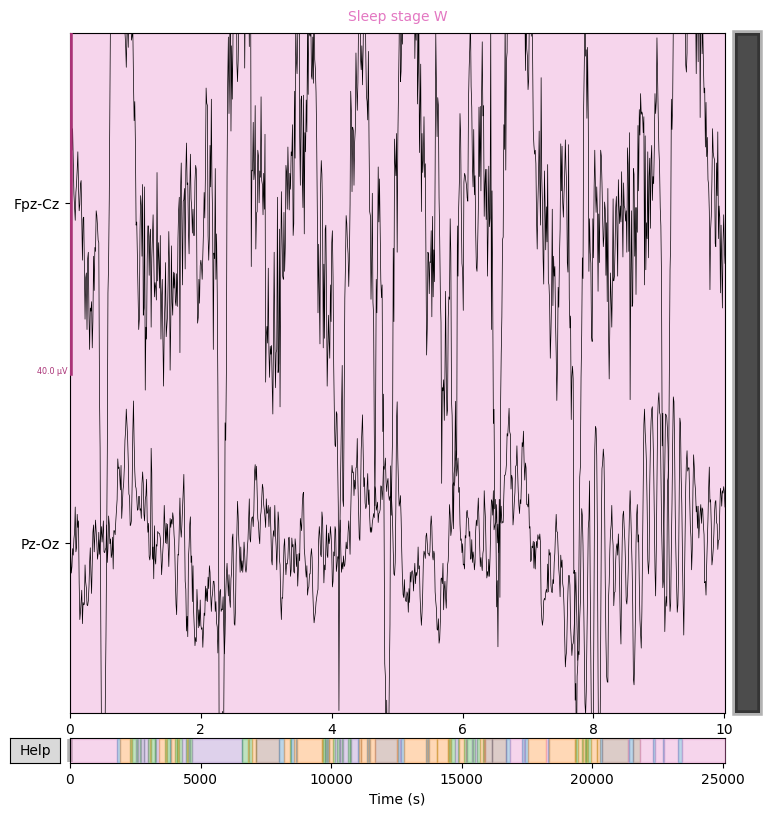

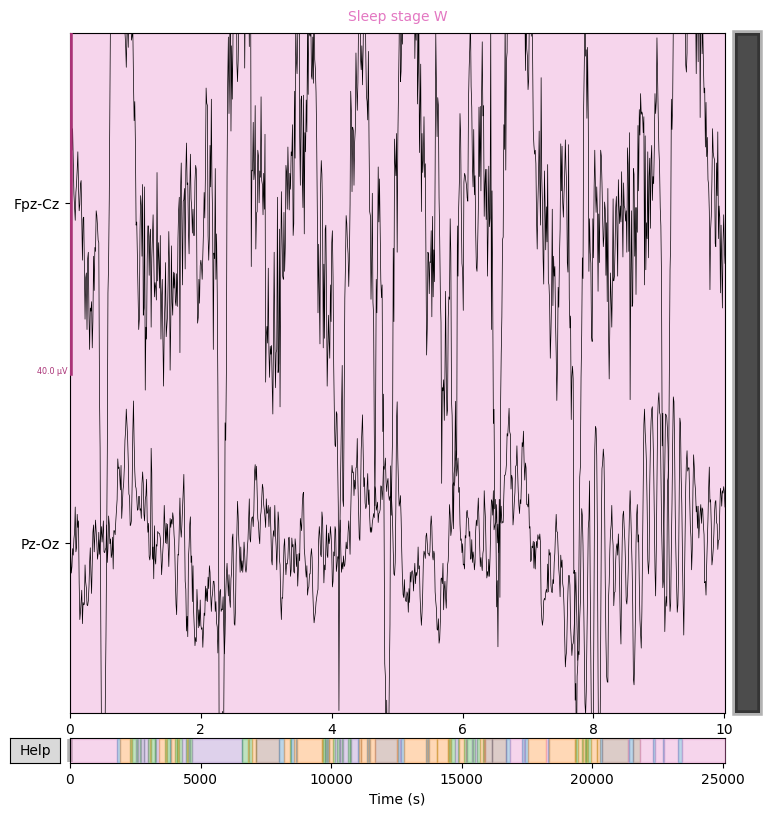

In [13]:
raws[0].plot()

In [14]:
l_freq, h_freq = None, 30

for raw in raws:
    raw.load_data().filter(l_freq, h_freq)
    print(l_freq, " ",h_freq)

None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30
None   30


In [15]:
# raws[0].plot_psd()
# print(raws[0])

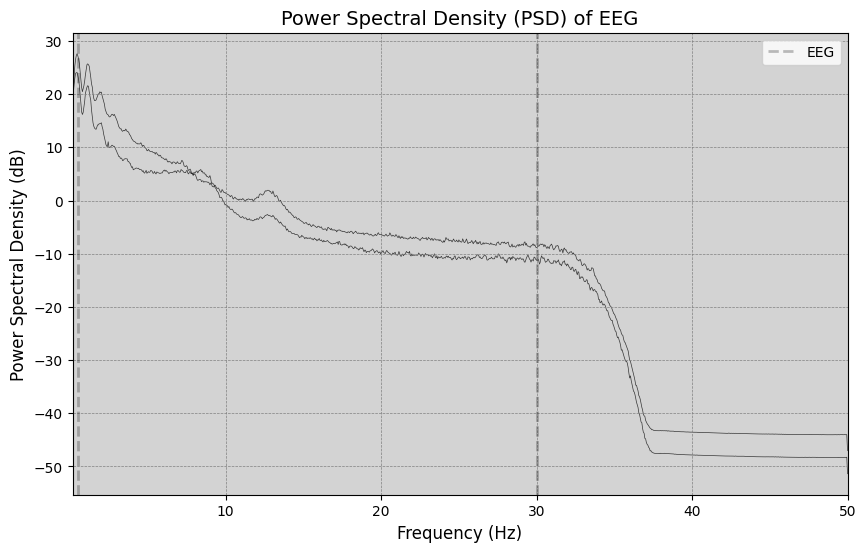

<RawEDF | SC4001E0-PSG.edf, 2 x 2508001 (25080.0 s), ~38.3 MB, data loaded>


In [16]:

# Load your raw data using the function
# Example: raw = load_sleep_physionet_raw('your_raw_file.edf', 'your_annotation_file.csv')

# Now, let's enhance the PSD plot visualization
raw = raws[0]  # Assuming raws[0] is already loaded
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the PSD
raw.plot_psd(ax=ax, fmin=0.1, fmax=50, color='green', show=False)

# Set gray background and grid
ax.set_facecolor('lightgray')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# Add labels and title
ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Power Spectral Density (dB)', fontsize=12)
ax.set_title('Power Spectral Density (PSD) of EEG', fontsize=14)

# Customize ticks and legend
ax.tick_params(axis='both', which='major', labelsize=10, colors='black')
ax.legend(['EEG'], loc='upper right', fontsize=10)

plt.show()

# Optionally, print the raw object for information
print(raw)

In [ ]:
[d,f] = read(````)

In [17]:
def extract_epochs(raw, chunk_duration=30.):
    """Extract non-overlapping epochs from raw data.

    Parameters
    ----------
    raw : mne.io.Raw
        Raw data object to be windowed.
    chunk_duration : float
        Length of a window.

    Returns
    -------
    np.ndarray
        Epoched data, of shape (n_epochs, n_channels, n_times).
    np.ndarray
        Event identifiers for each epoch, shape (n_epochs,).
    """
    annotation_desc_2_event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3': 4,
        'Sleep stage 4': 4,
        'Sleep stage R': 5}

    events, _ = mne.events_from_annotations(
        raw, event_id=annotation_desc_2_event_id,
        chunk_duration=chunk_duration)

    # create a new event_id that unifies stages 3 and 4
    event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3/4': 4,
        'Sleep stage R': 5}

    tmax = 30. - 1. / raw.info['sfreq']  # tmax in included
    picks = mne.pick_types(raw.info, eeg=True, eog=True)
    epochs = mne.Epochs(raw=raw, events=events, picks=picks, preload=True,
                        event_id=event_id, tmin=0., tmax=tmax, baseline=None)

    return epochs.get_data(), epochs.events[:, 2] - 1

In [18]:
from torch.utils.data import Dataset, ConcatDataset


class EpochsDataset(Dataset):
    """Class to expose an MNE Epochs object as PyTorch dataset.

    Parameters
    ----------
    epochs_data : np.ndarray
        The epochs data, shape (n_epochs, n_channels, n_times).
    epochs_labels : np.ndarray
        The epochs labels, shape (n_epochs,)
    subj_nb: None | int
        Subject number.
    rec_nb: None | int
        Recording number.
    transform : callable | None
        The function to eventually apply to each epoch
        for preprocessing (e.g. scaling). Defaults to None.
    """
    def __init__(self, epochs_data, epochs_labels, subj_nb=None,
                 rec_nb=None, transform=None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels
        self.subj_nb = subj_nb
        self.rec_nb = rec_nb
        self.transform = transform

    def __len__(self):
        return len(self.epochs_labels)

    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.transform is not None:
            X = self.transform(X)
        X = torch.as_tensor(X[None, ...])
        return X, y


def scale(X):
    """Standard scaling of data along the last dimention.

    Parameters
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.

    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        The scaled signals.
    """
    X -= np.mean(X, axis=1, keepdims=True)
    return X / np.std(X, axis=1, keepdims=True)

In [19]:
# Apply windowing and move to pytorch dataset
all_datasets = [EpochsDataset(*extract_epochs(raw), subj_nb=raw.info['subject_info']['id'],
                              rec_nb=raw.info['subject_info']['rec_id'], transform=scale)
                for raw in raws]

# Concatenate into a single dataset
dataset = ConcatDataset(all_datasets)

In [20]:
print(dataset)

In [21]:
# # Iterate over the dataset and print each epoch's data and labels
# for i in range(len(dataset)):
#     X, y = dataset[i]
#     print(f"Epoch {i + 1}:\nData: {X}\nLabel: {y}\n")

#     # Break after a certain number of examples to avoid overwhelming output
#     if i >= 10:  # Adjust this number as needed
#         break
# # Iterate over the entire dataset and print the data
# for i, (X, y) in enumerate(dataset):
#     print(f"Epoch {i + 1}:\nData: {X}\nLabel: {y}\n")


In [22]:
# import pandas as pd

# # List to store all event data
# all_events = []

# def extract_epochs(raw, chunk_duration=30.):
#     """Extract non-overlapping epochs from raw data and collect events."""
#     annotation_desc_2_event_id = {
#         'Sleep stage W': 1,
#         'Sleep stage 1': 2,
#         'Sleep stage 2': 3,
#         'Sleep stage 3': 4,
#         'Sleep stage 4': 4,
#         'Sleep stage R': 5}

#     events, _ = mne.events_from_annotations(
#         raw, event_id=annotation_desc_2_event_id,
#         chunk_duration=chunk_duration)
    
#     # Collect event data
#     all_events.append(events)
    
#     # Rest of your existing code
#     event_id = {
#         'Sleep stage W': 1,
#         'Sleep stage 1': 2,
#         'Sleep stage 2': 3,
#         'Sleep stage 3/4': 4,
#         'Sleep stage R': 5}

#     tmax = 30. - 1. / raw.info['sfreq']
#     picks = mne.pick_types(raw.info, eeg=True, eog=True)
#     epochs = mne.Epochs(raw=raw, events=events, picks=picks, preload=True,
#                         event_id=event_id, tmin=0., tmax=tmax, baseline=None)

#     return epochs.get_data(), epochs.events[:, 2] - 1


In [23]:
# # Apply windowing and move to PyTorch dataset
# all_datasets = [EpochsDataset(*extract_epochs(raw), subj_nb=raw.info['subject_info']['id'],
#                               rec_nb=raw.info['subject_info']['rec_id'], transform=scale)
#                 for raw in raws]

# # Concatenate into a single dataset
# dataset = ConcatDataset(all_datasets)

# # Flatten the all_events list and convert to a DataFrame
# # flat_events = [event for events in all_events for event in events]
# # df = pd.DataFrame(flat_events, columns=["Time", "Event Type", "Stage"])

# # Save to Excel
# # df.to_excel("events_data.xlsx", index=False)


In [24]:
# print(subj_rec_nbs)

In [25]:
from sklearn.model_selection import LeavePGroupsOut


def pick_recordings(dataset, subj_rec_nbs):
    """Pick recordings using subject and recording numbers.

    Parameters
    ----------
    dataset : ConcatDataset
        The dataset to pick recordings from.
    subj_rec_nbs : list of tuples
        List of pairs (subj_nb, rec_nb) to use in split.

    Returns
    -------
    ConcatDataset
        The picked recordings.
    ConcatDataset | None
        The remaining recordings. None if all recordings from
        `dataset` were picked.
    """
    pick_idx = list()
    for subj_nb, rec_nb in subj_rec_nbs:
        for i, ds in enumerate(dataset.datasets):
            if (ds.subj_nb == subj_nb) and (ds.rec_nb == rec_nb):
                pick_idx.append(i)

    remaining_idx = np.setdiff1d(
        range(len(dataset.datasets)), pick_idx)

    pick_ds = ConcatDataset([dataset.datasets[i] for i in pick_idx])
    if len(remaining_idx) > 0:
        remaining_ds = ConcatDataset(
            [dataset.datasets[i] for i in remaining_idx])
    else:
        remaining_ds = None

    return pick_ds, remaining_ds


def train_test_split(dataset, n_groups, split_by='subj_nb'):
    """Split dataset into train and test keeping n_groups out in test.

    Parameters
    ----------
    dataset : ConcatDataset
        The dataset to split.
    n_groups : int
        The number of groups to leave out.
    split_by : 'subj_nb' | 'rec_nb'
        Property to use to split dataset.

    Returns
    -------
    ConcatDataset
        The training data.
    ConcatDataset
        The testing data.
    """
    groups = [getattr(ds, split_by) for ds in dataset.datasets]
    train_idx, test_idx = next(
        LeavePGroupsOut(n_groups).split(X=groups, groups=groups))

    train_ds = ConcatDataset([dataset.datasets[i] for i in train_idx])
    test_ds = ConcatDataset([dataset.datasets[i] for i in test_idx])

    return train_ds, test_ds

In [26]:
torch.manual_seed(87)
np.random.seed(87)

In [27]:
test_recs = [(subj_nb, rec_nb)  # DO NOT CHANGE! This is a fixed set.
             for subj_nb, rec_nb in zip(range(10), [1] * 10)]
test_ds, train_ds = pick_recordings(dataset, test_recs)

In [28]:
# Split remaining recordings into training and validation sets
n_subjects_valid = max(1, int(len(train_ds.datasets) * 0.2))
train_ds, valid_ds = train_test_split(train_ds, n_subjects_valid, split_by='subj_nb')

print('Number of examples in each set:')
print(f'Training: {len(train_ds)}')
print(f'Validation: {len(valid_ds)}')
print(f'Test: {len(test_ds)}')

Number of examples in each set:
Training: 19569
Validation: 4185
Test: 9850


C:\Users\anshm\AppData\Local\Temp\ipykernel_21316\1914473607.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=datasets, y=examples_count, palette=colors)


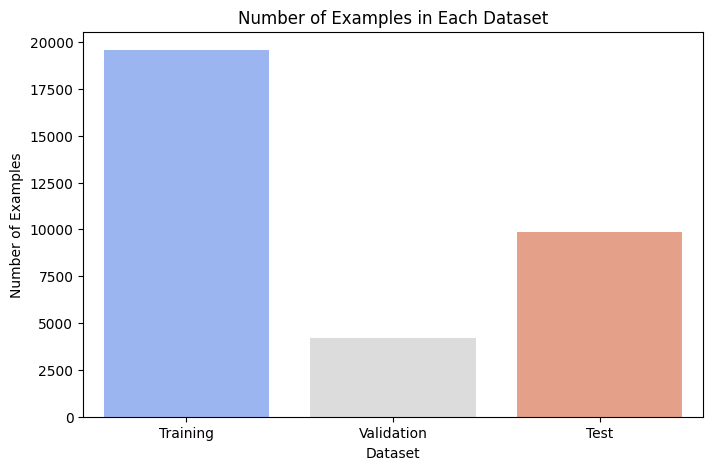

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data for each set
datasets = ['Training', 'Validation', 'Test']
examples_count = [len(train_ds), len(valid_ds), len(test_ds)]

# Create a custom colormap from blue to yellow
colors = sns.color_palette("coolwarm", as_cmap=False, n_colors=len(datasets))

# Create the bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=datasets, y=examples_count, palette=colors)

# Add labels and title
plt.xlabel('Dataset')
plt.ylabel('Number of Examples')
plt.title('Number of Examples in Each Dataset')

# Show the plot
plt.show()


In [30]:
# Assuming `test_ds` and `train_ds` are of type ConcatDataset

# Function to print a dataset
def print_dataset(dataset, name, num_samples=5):
    print(f"{name} Dataset (showing up to {num_samples} samples):")
    for i in range(min(num_samples, len(dataset))):
        print(f"Sample {i + 1}: {dataset[i]}")

# Print test_ds
print_dataset(test_ds, "Test")

# Print train_ds
print_dataset(train_ds, "Train")

# If you want to print the total number of samples in each dataset
print(f"Total samples in Test Dataset: {len(test_ds)}")
print(f"Total samples in Train Dataset: {len(train_ds)}")


Test Dataset (showing up to 5 samples):
Sample 1: (tensor([[[ 0.3887,  0.9346,  0.8632,  ..., -0.4731, -0.4901, -0.2084],
         [-0.2036, -0.2689, -0.6394,  ...,  0.3970,  0.5562,  0.0466]]],
       dtype=torch.float64), 0)
Sample 2: (tensor([[[-0.3449, -0.5448, -0.2146,  ...,  2.0421,  1.9188,  2.1202],
         [-0.2583, -0.1376, -0.2634,  ...,  0.6086,  1.3655,  0.7621]]],
       dtype=torch.float64), 0)
Sample 3: (tensor([[[ 1.7403,  1.4080,  1.3783,  ...,  1.0748,  1.0731,  0.9778],
         [ 0.4591,  1.5401,  2.3674,  ...,  0.0124, -0.2490, -0.6441]]],
       dtype=torch.float64), 0)
Sample 4: (tensor([[[ 1.0666,  0.9667,  0.8461,  ...,  0.8697,  1.6358,  2.2361],
         [-0.3507,  0.0254,  0.0964,  ...,  0.2286,  0.2047,  0.2401]]],
       dtype=torch.float64), 0)
Sample 5: (tensor([[[ 2.3228,  2.5980,  2.7553,  ...,  0.4782,  0.9377,  1.2709],
         [ 0.4562,  0.2937, -0.2518,  ..., -0.0408,  0.1599,  0.2249]]],
       dtype=torch.float64), 0)
Train Dataset (showing up

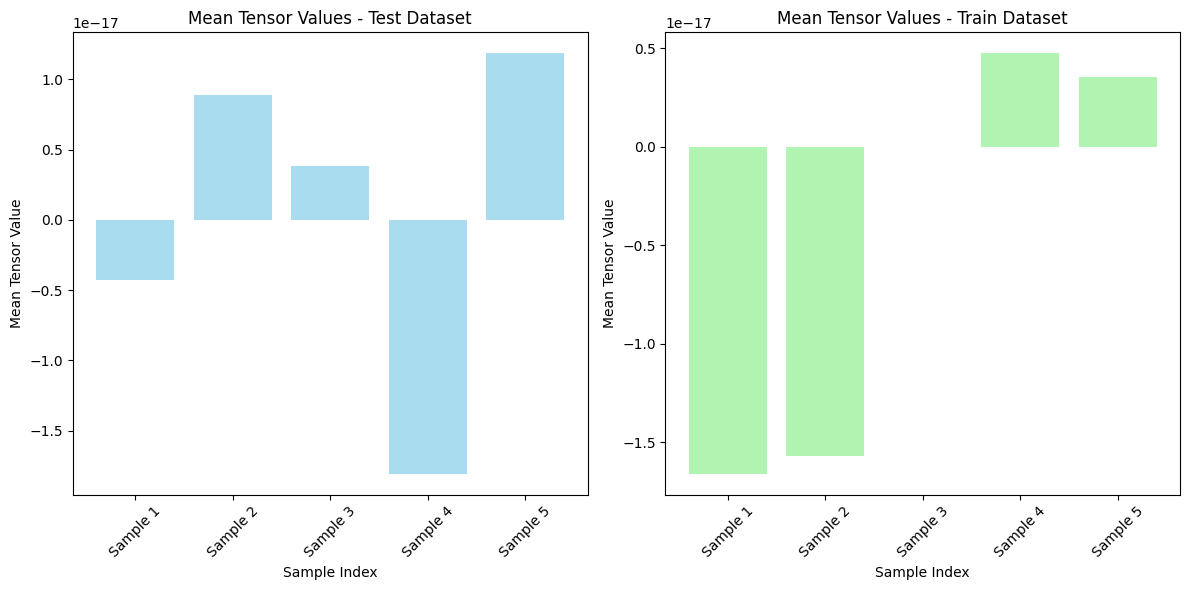

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Function to extract the mean tensor values for visualization (or customize as needed)
def extract_tensor_means(dataset, num_samples=5):
    tensor_means = []
    labels = []
    
    for i in range(min(num_samples, len(dataset))):
        sample = dataset[i]
        tensor, label = sample
        
        # Compute the mean of the tensor (or use another aggregation method)
        tensor_mean = tensor.mean().item()  # Convert to Python float
        tensor_means.append(tensor_mean)
        labels.append(label)
        
    return tensor_means, labels

# Extract means from the test and train datasets (showing 5 samples)
test_means, test_labels = extract_tensor_means(test_ds, num_samples=5)
train_means, train_labels = extract_tensor_means(train_ds, num_samples=5)

# Set up the plot
plt.figure(figsize=(12, 6))

# Create the bar plot for the Test Dataset
plt.subplot(1, 2, 1)
plt.bar(np.arange(len(test_means)), test_means, color='skyblue', alpha=0.7)
plt.title('Mean Tensor Values - Test Dataset')
plt.xlabel('Sample Index')
plt.ylabel('Mean Tensor Value')
plt.xticks(np.arange(len(test_means)), [f'Sample {i+1}' for i in range(len(test_means))], rotation=45)

# Create the bar plot for the Train Dataset
plt.subplot(1, 2, 2)
plt.bar(np.arange(len(train_means)), train_means, color='lightgreen', alpha=0.7)
plt.title('Mean Tensor Values - Train Dataset')
plt.xlabel('Sample Index')
plt.ylabel('Mean Tensor Value')
plt.xticks(np.arange(len(train_means)), [f'Sample {i+1}' for i in range(len(train_means))], rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


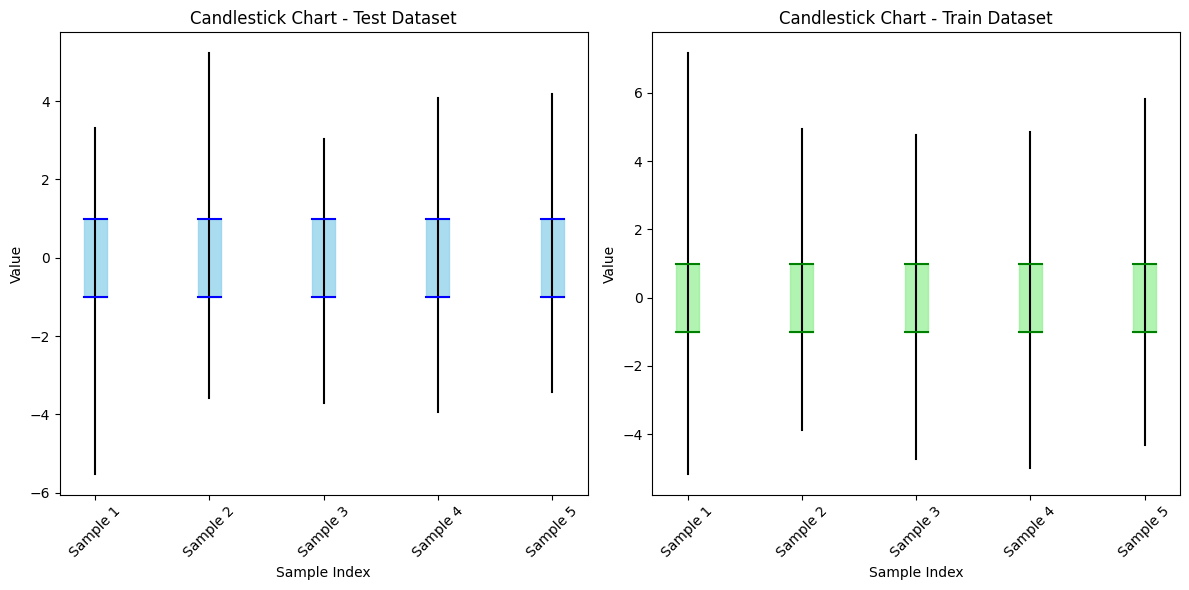

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Function to extract stats (min, max, mean, std) for each tensor
def extract_tensor_stats(dataset, num_samples=5):
    tensor_stats = []
    
    for i in range(min(num_samples, len(dataset))):
        sample = dataset[i]
        tensor, label = sample
        
        # Compute stats
        tensor_min = tensor.min().item()
        tensor_max = tensor.max().item()
        tensor_mean = tensor.mean().item()
        tensor_std = tensor.std().item()
        
        tensor_stats.append((tensor_min, tensor_max, tensor_mean, tensor_std))
    
    return tensor_stats

# Extract stats from the test and train datasets (showing 5 samples)
test_stats = extract_tensor_stats(test_ds, num_samples=5)
train_stats = extract_tensor_stats(train_ds, num_samples=5)

# Convert stats into NumPy arrays for easy plotting
test_stats = np.array(test_stats)
train_stats = np.array(train_stats)

# Set up the plot for candle graph
plt.figure(figsize=(12, 6))

# Plot for the Test Dataset
plt.subplot(1, 2, 1)
for i in range(len(test_stats)):
    # Plot the line between min and max (the "wick" of the candle)
    plt.plot([i, i], [test_stats[i, 0], test_stats[i, 1]], color='black')
    # Plot the candle (mean +/- std as the "body" of the candle)
    plt.plot([i-0.1, i+0.1], [test_stats[i, 2] - test_stats[i, 3], test_stats[i, 2] - test_stats[i, 3]], color='blue')
    plt.plot([i-0.1, i+0.1], [test_stats[i, 2] + test_stats[i, 3], test_stats[i, 2] + test_stats[i, 3]], color='blue')
    plt.fill_between([i-0.1, i+0.1], test_stats[i, 2] - test_stats[i, 3], test_stats[i, 2] + test_stats[i, 3], color='skyblue', alpha=0.7)
    
plt.title('Candlestick Chart - Test Dataset')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.xticks(np.arange(len(test_stats)), [f'Sample {i+1}' for i in range(len(test_stats))], rotation=45)

# Plot for the Train Dataset
plt.subplot(1, 2, 2)
for i in range(len(train_stats)):
    # Plot the line between min and max (the "wick" of the candle)
    plt.plot([i, i], [train_stats[i, 0], train_stats[i, 1]], color='black')
    # Plot the candle (mean +/- std as the "body" of the candle)
    plt.plot([i-0.1, i+0.1], [train_stats[i, 2] - train_stats[i, 3], train_stats[i, 2] - train_stats[i, 3]], color='green')
    plt.plot([i-0.1, i+0.1], [train_stats[i, 2] + train_stats[i, 3], train_stats[i, 2] + train_stats[i, 3]], color='green')
    plt.fill_between([i-0.1, i+0.1], train_stats[i, 2] - train_stats[i, 3], train_stats[i, 2] + train_stats[i, 3], color='lightgreen', alpha=0.7)

plt.title('Candlestick Chart - Train Dataset')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.xticks(np.arange(len(train_stats)), [f'Sample {i+1}' for i in range(len(train_stats))], rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [33]:
# print("test_ds",test_ds)
# print("train_ds",train_ds)

In [34]:
# # To check the contents of test_ds and train_ds
# print("Test Dataset:")
# for ds in test_ds.datasets:
#     print(f"Subject: {ds.subj_nb}, Recording: {ds.rec_nb}")

# print("\nTrain Dataset:")
# if train_ds is not None:
#     for ds in train_ds.datasets:
#         print(f"Subject: {ds.subj_nb}, Recording: {ds.rec_nb}")
# else:
#     print("No remaining datasets.")


In [35]:
n_subjects_valid = max(1, int(len(train_ds.datasets) * 0.2))
train_ds, valid_ds = train_test_split(train_ds, n_subjects_valid, split_by='subj_nb')

print('Number of examples in each set:')
print(f'Training: {len(train_ds)}')
print(f'Validation: {len(valid_ds)}')
print(f'Test: {len(test_ds)}')

Number of examples in each set:
Training: 16602
Validation: 2967
Test: 9850


In [36]:
# import numpy as np
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split

# # Example Dataset class (replace with your actual dataset)
# class ExampleDataset(Dataset):
#     def __init__(self, data, labels):
#         self.data = data
#         self.labels = labels

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx], self.labels[idx]

# # Example data (replace with your actual data and labels)
# data = np.random.randn(1000, 1, 128, 128).astype(np.float32)
# labels = np.random.randint(0, 5, 1000)

# # Assuming 'subj_nb' is a placeholder for subject numbers (if applicable)
# subject_numbers = np.random.randint(0, 100, 1000)  # Example subject numbers

# # Split the data into training and validation sets
# n_subjects_valid = max(1, int(len(data) * 0.2))
# train_data, valid_data, train_labels, valid_labels = train_test_split(
#     data, labels, test_size=n_subjects_valid, stratify=subject_numbers)

# # Create Dataset instances
# train_ds = ExampleDataset(train_data, train_labels)
# valid_ds = ExampleDataset(valid_data, valid_labels)
# test_ds = ExampleDataset(np.random.randn(200, 1, 128, 128).astype(np.float32), np.random.randint(0, 5, 200))

# # Print the number of examples in each set
# print('Number of examples in each set:')
# print(f'Training: {len(train_ds)}')
# print(f'Validation: {len(valid_ds)}')
# print(f'Test: {len(test_ds)}')

# # Function to print detailed information about the datasets
# def print_dataset_details(dataset, dataset_name):
#     print(f"\n{dataset_name} Dataset Details:")
#     print(f"  Total examples: {len(dataset)}")
#     for i in range(min(2, len(dataset))):  # Only print details for a few examples
#         data, label = dataset[i]
#         print(f"\n  Example {i + 1}:")
#         print(f"    Data shape: {data.shape}")
#         print(f"    Data sample (first few elements): {data.flatten()[:10]}")  # Print first 10 elements
#         print(f"    Label: {label}")

# # Print details for each dataset
# print_dataset_details(train_ds, "Training")
# print_dataset_details(valid_ds, "Validation")
# print_dataset_details(test_ds, "Test")


In [37]:
# classes_mapping = {0: 'W', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'R'}
# y_train = pd.Series([y for _, y in train_ds]).map(classes_mapping)
# ax = y_train.value_counts().plot(kind='barh')
# ax.set_xlabel('Number of training examples');
# ax.set_ylabel('Sleep stage');

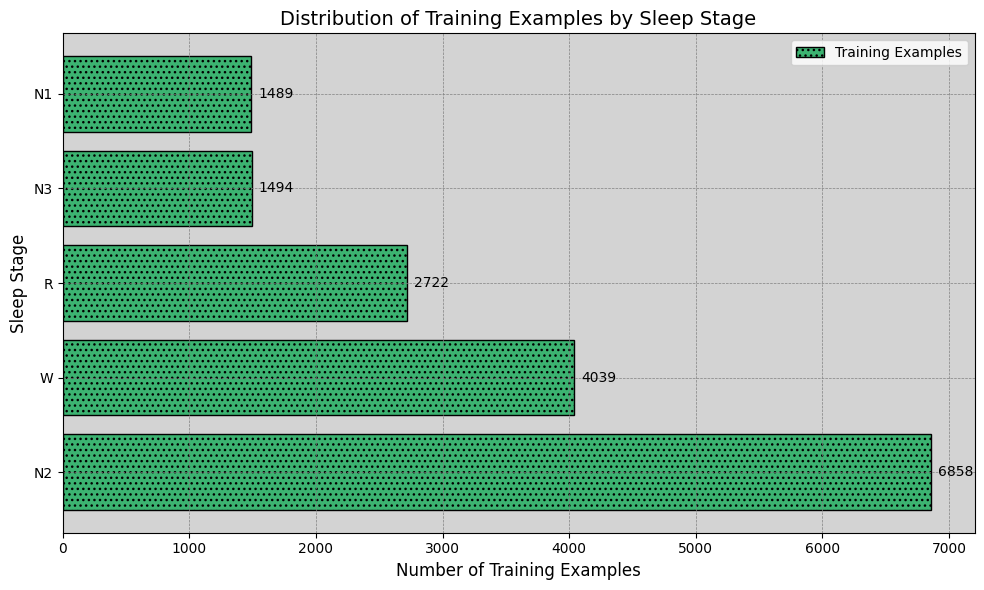

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Example data and mapping (assuming train_ds is already defined)
classes_mapping = {0: 'W', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'R'}
y_train = pd.Series([y for _, y in train_ds]).map(classes_mapping)

# Create the horizontal bar plot
fig, ax = plt.subplots(figsize=(10, 6))
value_counts = y_train.value_counts()

# Plot with a dotted pattern (hatching) and colors
bars = ax.barh(value_counts.index, value_counts.values, color='mediumseagreen', edgecolor='black', hatch='...')

# Set labels and title with custom styling
ax.set_xlabel('Number of Training Examples', fontsize=12, color='black')
ax.set_ylabel('Sleep Stage', fontsize=12, color='black')
ax.set_title('Distribution of Training Examples by Sleep Stage', fontsize=14, color='black')

# Customize the plot background, grid
ax.set_facecolor('lightgray')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# Add bar labels with numeric values outside the bars
for bar in bars:
    width = bar.get_width()
    ax.annotate(f'{width}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(5, 0),  # 5 points horizontal offset to avoid touching the rectangle
                textcoords="offset points",
                ha='left', va='center', fontsize=10, color='black')

# Add a legend for the dot pattern
ax.legend(bars, ['Training Examples'], loc='upper right', fontsize=10)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()


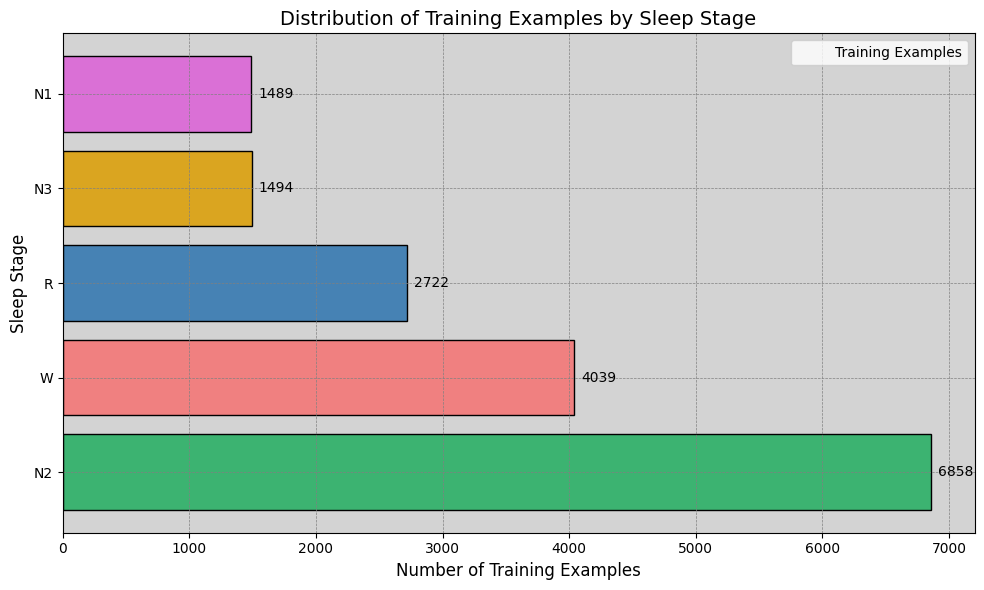

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Example data and mapping (assuming train_ds is already defined)
classes_mapping = {0: 'W', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'R'}
y_train = pd.Series([y for _, y in train_ds]).map(classes_mapping)

# Create the horizontal bar plot
fig, ax = plt.subplots(figsize=(10, 6))
value_counts = y_train.value_counts()

# Define a color palette (one color for each bar)
colors = ['mediumseagreen', 'lightcoral', 'steelblue', 'goldenrod', 'orchid']

# Plot with different colors for each bar
bars = ax.barh(value_counts.index, value_counts.values, color=colors, edgecolor='black', hatch='')

# Set labels and title with custom styling
ax.set_xlabel('Number of Training Examples', fontsize=12, color='black')
ax.set_ylabel('Sleep Stage', fontsize=12, color='black')
ax.set_title('Distribution of Training Examples by Sleep Stage', fontsize=14, color='black')

# Customize the plot background and grid
ax.set_facecolor('lightgray')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# Add bar labels with numeric values outside the bars
for bar in bars:
    width = bar.get_width()
    ax.annotate(f'{width}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(5, 0),  # 5 points horizontal offset to avoid touching the rectangle
                textcoords="offset points",
                ha='left', va='center', fontsize=10, color='black')

# Add a legend without the rectangle (only the name "Training Examples")
# Create a blank Rectangle and add it to the legend
blank_patch = Rectangle((0, 0), 1, 1, fill=False, edgecolor='none', visible=False)
ax.legend([blank_patch], ['Training Examples'], loc='upper right', fontsize=10)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()


In [39]:
# Computing class weight
from sklearn.utils.class_weight import compute_class_weight

train_y = np.concatenate([ds.epochs_labels for ds in train_ds.datasets])
class_weights = compute_class_weight('balanced', classes=np.unique(train_y), y=train_y)
print(class_weights)

[0.82208467 2.22995299 0.48416448 2.22248996 1.21983835]


In [40]:
print(class_weights)

[0.82208467 2.22995299 0.48416448 2.22248996 1.21983835]


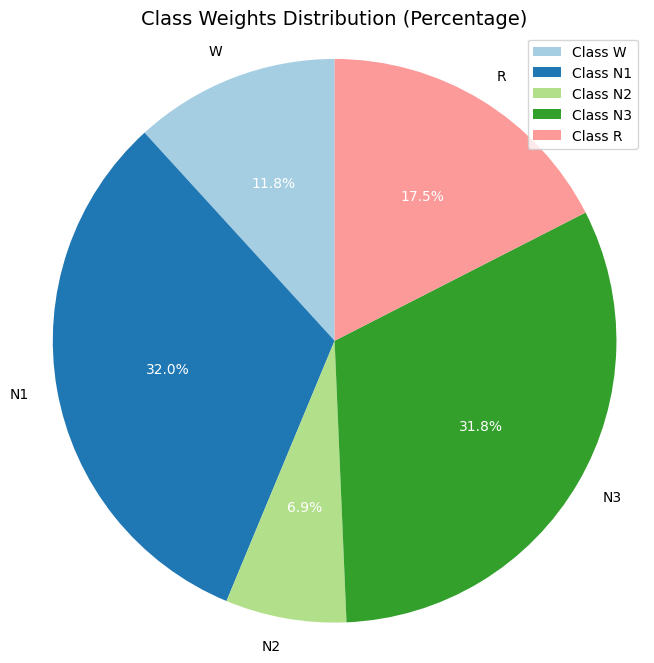

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Define the class names and their corresponding weights
class_names = ['W', 'N1', 'N2', 'N3', 'R']
# class_weights = np.array([0.2, 0.3, 0.1, 0.1, 0.3])  # Replace with your actual class weights

# Define colors for the pie chart
colors = plt.cm.Paired.colors[:len(class_names)]

# Plotting the pie chart with class weights
plt.figure(figsize=(8, 8))
patches, texts, autotexts = plt.pie(class_weights, labels=class_names, autopct='%1.1f%%', colors=colors, startangle=90)

# Adding title
plt.title('Class Weights Distribution (Percentage)', fontsize=14)

# Adding legend
plt.legend(patches, [f'Class {cls}' for cls in class_names], loc="best")

# Beautifying the chart
for text in autotexts:
    text.set_color('white')  # Make the percentage text color white for better readability

# Show the pie chart
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


In [42]:
from torch import nn


class SleepStagerChambon2018(nn.Module):
    """Sleep staging architecture from [1]_.

    Convolutional neural network for sleep staging described in [1]_.

    Parameters
    ----------
    n_channels : int
        Number of EEG channels.
    sfreq : float
        EEG sampling frequency.
    n_conv_chs : int
        Number of convolutional channels. Set to 8 in [1]_.
    time_conv_size_s : float
        Size of filters in temporal convolution layers, in seconds. Set to 0.5
        in [1]_ (64 samples at sfreq=128).
    max_pool_size_s : float
        Max pooling size, in seconds. Set to 0.125 in [1]_ (16 samples at
        sfreq=128).
    n_classes : int
        Number of classes.
    input_size_s : float
        Size of the input, in seconds.
    dropout : float
        Dropout rate before the output dense layer.

    References
    ----------
    .. [1] Chambon, S., Galtier, M. N., Arnal, P. J., Wainrib, G., &
           Gramfort, A. (2018). A deep learning architecture for temporal sleep
           stage classification using multivariate and multimodal time series.
           IEEE Transactions on Neural Systems and Rehabilitation Engineering,
           26(4), 758-769.
    """
    def __init__(self, n_channels, sfreq, n_conv_chs=8, time_conv_size_s=0.5,
                 max_pool_size_s=0.125, n_classes=5, input_size_s=30,
                 dropout=0.25):
        super().__init__()

        time_conv_size = int(time_conv_size_s * sfreq)
        max_pool_size = int(max_pool_size_s * sfreq)
        input_size = int(input_size_s * sfreq)
        pad_size = time_conv_size // 2
        self.n_channels = n_channels
        len_last_layer = self._len_last_layer(
            n_channels, input_size, max_pool_size, n_conv_chs)

        if n_channels > 1:
            self.spatial_conv = nn.Conv2d(1, n_channels, (n_channels, 1))

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                1, n_conv_chs, (1, time_conv_size), padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size)),
            nn.Conv2d(
                n_conv_chs, n_conv_chs, (1, time_conv_size),
                padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size))
        )
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(len_last_layer, n_classes)
        )

    @staticmethod
    def _len_last_layer(n_channels, input_size, max_pool_size, n_conv_chs):
        return n_channels * (input_size // (max_pool_size ** 2)) * n_conv_chs

    def forward(self, x):
        """Forward pass.

        Parameters
        ---------
        x: torch.Tensor
            Batch of EEG windows of shape (batch_size, n_channels, n_times).
        """
        if self.n_channels > 1:
            x = self.spatial_conv(x)
            x = x.transpose(1, 2)

        x = self.feature_extractor(x)
        return self.fc(x.flatten(start_dim=1))

In [43]:
model = SleepStagerChambon2018(n_channels=1, sfreq=128, n_classes=5)
print(model)


SleepStagerChambon2018(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 16), stride=(1, 16), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(1, 16), stride=(1, 16), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=120, out_features=5, bias=True)
  )
)


In [44]:
sfreq = raws[0].info['sfreq']  # Sampling frequency
n_channels = raws[0].info['nchan']  # Number of channels

model = SleepStagerChambon2018(n_channels, sfreq, n_classes=5)

In [45]:
print(model)

SleepStagerChambon2018(
  (spatial_conv): Conv2d(1, 2, kernel_size=(2, 1), stride=(1, 1))
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 12), stride=(1, 12), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(1, 12), stride=(1, 12), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=320, out_features=5, bias=True)
  )
)


In [46]:
print(sfreq)
print(n_channels)

100.0
2


In [47]:
print(f'Using device \'{device}\'.')
model = model.to(device)

Using device 'cpu'.


In [48]:
from torch.utils.data import DataLoader

# Create dataloaders
train_batch_size = 128  # Important hyperparameter
valid_batch_size = 256  # Can be made as large as what fits in memory; won't impact performance
num_workers = 0  # Number of processes to use for the data loading process; 0 is the main Python process

loader_train = DataLoader(
    train_ds, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
loader_valid = DataLoader(
    valid_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)
loader_test = DataLoader(
    test_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)

In [49]:
for batch in loader_train:
    inputs, labels = batch
    print(input," -----------------",labels)
    # Forward pass, loss computation, backpropagation, etc.


<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x000001E15C95AE10>>  ----------------- tensor([0, 1, 2, 0, 2, 3, 0, 0, 2, 2, 0, 4, 2, 2, 0, 0, 1, 3, 3, 4, 2, 2, 0, 2,
        0, 2, 4, 2, 3, 0, 4, 4, 2, 2, 2, 4, 2, 2, 2, 0, 2, 4, 4, 3, 0, 3, 2, 2,
        2, 0, 2, 3, 0, 2, 0, 2, 4, 2, 4, 2, 2, 1, 0, 1, 2, 4, 4, 2, 2, 0, 0, 4,
        2, 2, 2, 0, 3, 0, 0, 2, 2, 4, 0, 2, 2, 3, 1, 2, 0, 0, 4, 2, 0, 2, 2, 2,
        2, 0, 2, 2, 1, 0, 1, 0, 4, 0, 1, 2, 1, 0, 0, 2, 2, 2, 2, 2, 4, 2, 2, 2,
        2, 3, 2, 1, 0, 2, 2, 3], dtype=torch.int32)
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x000001E15C95AE10>>  ----------------- tensor([2, 0, 2, 4, 0, 0, 0, 4, 3, 0, 0, 0, 1, 4, 2, 2, 2, 0, 2, 2, 0, 2, 2, 1,
        2, 4, 3, 0, 2, 2, 2, 0, 2, 2, 4, 0, 2, 2, 4, 0, 0, 0, 2, 4, 2, 2, 2, 4,
        2, 0, 3, 4, 2, 2, 1, 0, 2, 0, 2, 2, 2, 3, 2, 4, 2, 2, 3, 4, 2, 0, 3, 1,
        3, 0, 4, 2, 3, 2, 1, 2, 1, 0, 2, 1, 2, 0, 0, 0, 2, 0, 0, 2, 3, 0

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x000001E15C95AE10>>  ----------------- tensor([4, 0, 2, 2, 3, 4, 0, 4, 0, 2, 0, 4, 4, 0, 0, 2, 2, 1, 4, 3, 2, 1, 2, 2,
        4, 2, 0, 1, 2, 0, 2, 0, 3, 0, 0, 4, 1, 1, 4, 4, 2, 1, 2, 3, 4, 2, 4, 3,
        2, 4, 1, 3, 0, 3, 2, 3, 2, 2, 0, 0, 0, 2, 4, 2, 1, 3, 3, 2, 2, 2, 2, 3,
        4, 2, 4, 4, 2, 2, 0, 2, 2, 4, 2, 4, 4, 0, 2, 1, 2, 0, 2, 4, 2, 0, 0, 2,
        0, 0, 2, 3, 2, 0, 4, 2, 0, 4, 2, 1, 0, 4, 2, 4, 2, 3, 4, 0, 1, 0, 0, 1,
        2, 0, 2, 0, 2, 2, 2, 2], dtype=torch.int32)
<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x000001E15C95AE10>>  ----------------- tensor([4, 3, 3, 2, 4, 2, 1, 2, 0, 0, 2, 2, 1, 2, 2, 1, 0, 0, 2, 2, 2, 0, 0, 3,
        0, 0, 2, 2, 2, 4, 0, 0, 2, 2, 2, 3, 2, 2, 4, 2, 0, 1, 4, 0, 1, 2, 4, 2,
        0, 4, 0, 2, 0, 1, 0, 2, 4, 0, 0, 2, 1, 1, 0, 2, 2, 3, 2, 2, 0, 2, 0, 2,
        4, 4, 1, 0, 3, 4, 0, 4, 2, 4, 4, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0

In [50]:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score

def _do_train(model, loader, optimizer, criterion, device, metric):
    # training loop
    model.train()

    train_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()
    for idx_batch, (batch_x, batch_y) in enumerate(loader):
        optimizer.zero_grad()
        batch_x = batch_x.to(device=device, dtype=torch.float32)
        batch_y = batch_y.to(device=device, dtype=torch.int64)

        output = model(batch_x)
        loss = criterion(output, batch_y)

        loss.backward()
        optimizer.step()

        y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
        y_true_all.append(batch_y.cpu().numpy())

        train_loss[idx_batch] = loss.item()

    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)

    return np.mean(train_loss), perf


def _validate(model, loader, criterion, device, metric):
    # validation loop
    model.eval()

    val_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()
    with torch.no_grad():
        for idx_batch, (batch_x, batch_y) in enumerate(loader):
            batch_x = batch_x.to(device=device, dtype=torch.float32)
            batch_y = batch_y.to(device=device, dtype=torch.int64)
            output = model.forward(batch_x)

            loss = criterion(output, batch_y)
            val_loss[idx_batch] = loss.item()

            y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
            y_true_all.append(batch_y.cpu().numpy())

    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)

    return np.mean(val_loss), perf


def train(model, loader_train, loader_valid, optimizer, criterion, n_epochs,
          patience, device, metric=None):
    """Training function.

    Parameters
    ----------
    model : instance of nn.Module
        The model.
    loader_train : instance of Sampler
        The generator of EEG samples the model has to train on.
        It contains n_train samples
    loader_valid : instance of Sampler
        The generator of EEG samples the model has to validate on.
        It contains n_val samples. The validation samples are used to
        monitor the training process and to perform early stopping
    optimizer : instance of optimizer
        The optimizer to use for training.
    n_epochs : int
        The maximum of epochs to run.
    patience : int
        The patience parameter, i.e. how long to wait for the
        validation error to go down.
    metric : None | callable
        Metric to use to evaluate performance on the training and
        validation sets. Defaults to balanced accuracy.

    Returns
    -------
    best_model : instance of nn.Module
        The model that led to the best prediction on the validation
        dataset.
    history : list of dicts
        Training history (loss, accuracy, etc.)
    """
    best_valid_loss = np.inf
    best_model = copy.deepcopy(model)
    waiting = 0
    history = list()

    if metric is None:
        metric = balanced_accuracy_score

    print('epoch \t train_loss \t valid_loss \t train_perf \t valid_perf')
    print('-------------------------------------------------------------------')

    for epoch in range(1, n_epochs + 1):
        train_loss, train_perf = _do_train(
            model, loader_train, optimizer, criterion, device, metric=metric)
        valid_loss, valid_perf = _validate(
            model, loader_valid, criterion, device, metric=metric)
        history.append(
            {'epoch': epoch,
             'train_loss': train_loss, 'valid_loss': valid_loss,
             'train_perf': train_perf, 'valid_perf': valid_perf})

        print(f'{epoch} \t {train_loss:0.4f} \t {valid_loss:0.4f} '
              f'\t {train_perf:0.4f} \t {valid_perf:0.4f}')

        # model saving
        if valid_loss < best_valid_loss:
            print(f'best val loss {best_valid_loss:.4f} -> {valid_loss:.4f}')
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            waiting = 0
        else:
            waiting += 1

        # model early stopping
        if waiting >= patience:
            print(f'Stop training at epoch {epoch}')
            print(f'Best val loss : {best_valid_loss:.4f}')
            break

    return best_model, history

In [51]:
# print(f"Epoch {epoch}: Train Loss = {train_loss}, Train Perf = {train_perf}")
# print(f"Epoch {epoch}: Valid Loss = {valid_loss}, Valid Perf = {valid_perf}")

In [52]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0)
criterion = CrossEntropyLoss(weight=torch.Tensor(class_weights).to(device))

In [53]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [54]:
print(criterion)

CrossEntropyLoss()


In [55]:
print(f'Using device \'{device}\'.')
model = model.to(device)

Using device 'cpu'.


In [56]:
n_epochs = 10
patience = 5

best_model, history = train(
    model, loader_train, loader_valid, optimizer, criterion, n_epochs, patience,
    device, metric=cohen_kappa_score)

epoch 	 train_loss 	 valid_loss 	 train_perf 	 valid_perf
-------------------------------------------------------------------
1 	 1.2983 	 0.9318 	 0.2467 	 0.4685
best val loss inf -> 0.9318
2 	 0.9996 	 0.8345 	 0.4431 	 0.5165
best val loss 0.9318 -> 0.8345
3 	 0.9047 	 0.7266 	 0.5011 	 0.5716
best val loss 0.8345 -> 0.7266
4 	 0.8237 	 0.6793 	 0.5541 	 0.6033
best val loss 0.7266 -> 0.6793
5 	 0.7635 	 0.6241 	 0.5989 	 0.6120
best val loss 0.6793 -> 0.6241
6 	 0.7085 	 0.5680 	 0.6360 	 0.7354
best val loss 0.6241 -> 0.5680
7 	 0.6705 	 0.5594 	 0.6558 	 0.7023
best val loss 0.5680 -> 0.5594
8 	 0.6634 	 0.4916 	 0.6517 	 0.7698
best val loss 0.5594 -> 0.4916
9 	 0.6345 	 0.4959 	 0.6745 	 0.7830
10 	 0.6168 	 0.4959 	 0.6762 	 0.7565


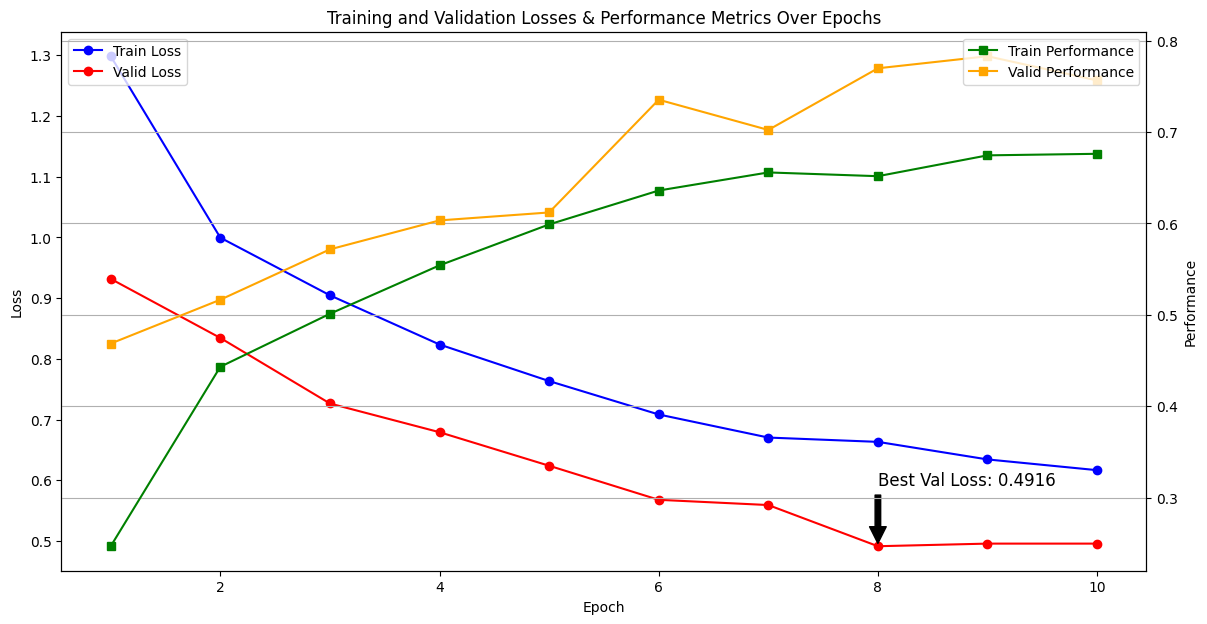

In [57]:
import matplotlib.pyplot as plt

# Data from your training process
epochs = list(range(1, 11))
train_loss = [1.2983, 0.9996, 0.9047, 0.8237, 0.7635, 0.7085, 0.6705, 0.6634, 0.6345, 0.6168]
valid_loss = [0.9318, 0.8345, 0.7266, 0.6793, 0.6241, 0.5680, 0.5594, 0.4916, 0.4959, 0.4959]
train_perf = [0.2467, 0.4431, 0.5011, 0.5541, 0.5989, 0.6360, 0.6558, 0.6517, 0.6745, 0.6762]
valid_perf = [0.4685, 0.5165, 0.5716, 0.6033, 0.6120, 0.7354, 0.7023, 0.7698, 0.7830, 0.7565]

# Create subplots
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot training and validation losses
ax1.plot(epochs, train_loss, 'o-', color='blue', label='Train Loss')
ax1.plot(epochs, valid_loss, 'o-', color='red', label='Valid Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Losses & Performance Metrics Over Epochs')
ax1.legend(loc='upper left')

# Create a second y-axis for performance metrics
ax2 = ax1.twinx()
ax2.plot(epochs, train_perf, 's-', color='green', label='Train Performance')
ax2.plot(epochs, valid_perf, 's-', color='orange', label='Valid Performance')
ax2.set_ylabel('Performance', color='black')
ax2.legend(loc='upper right')

# Highlight the best validation loss
best_val_loss = min(valid_loss)
best_epoch = valid_loss.index(best_val_loss) + 1
ax1.annotate(f'Best Val Loss: {best_val_loss:.4f}', xy=(best_epoch, best_val_loss), 
             xytext=(best_epoch, best_val_loss + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, color='black')

# Show the plot
plt.grid()
plt.show()


In [58]:
print(best_model)

SleepStagerChambon2018(
  (spatial_conv): Conv2d(1, 2, kernel_size=(2, 1), stride=(1, 1))
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 12), stride=(1, 12), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(1, 12), stride=(1, 12), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=320, out_features=5, bias=True)
  )
)


In [59]:
# history_df = pd.DataFrame(history)
# ax1 = history_df.plot(x='epoch', y=['train_loss', 'valid_loss'], marker='o')
# ax1.set_ylabel('Loss')
# ax2 = history_df.plot(x='epoch', y=['train_perf', 'valid_perf'], marker='o')
# ax2.set_ylabel('Cohen\'s kappa')

In [60]:
# import pandas as pd
# import plotly.graph_objs as go
# from plotly.subplots import make_subplots

# # Example history data (assuming `history` is defined)
# history_df = pd.DataFrame(history)

# # Create subplots: two rows, one column
# fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1,
#                     subplot_titles=("Loss vs. Epoch", "Cohen's Kappa vs. Epoch"))

# # Plot the loss curves
# fig.add_trace(go.Scatter(x=history_df['epoch'], y=history_df['train_loss'],
#                          mode='lines+markers', name='Train Loss',
#                          marker=dict(color='aqua')),
#               row=1, col=1)

# fig.add_trace(go.Scatter(x=history_df['epoch'], y=history_df['valid_loss'],
#                          mode='lines+markers', name='Valid Loss',
#                          marker=dict(color='goldenrod')),
#               row=1, col=1)

# # Plot the Cohen's kappa curves
# fig.add_trace(go.Scatter(x=history_df['epoch'], y=history_df['train_perf'],
#                          mode='lines+markers', name='Train Cohen\'s Kappa',
#                          marker=dict(color='aqua')),
#               row=2, col=1)

# fig.add_trace(go.Scatter(x=history_df['epoch'], y=history_df['valid_perf'],
#                          mode='lines+markers', name='Valid Cohen\'s Kappa',
#                          marker=dict(color='goldenrod')),
#               row=2, col=1)

# # Update layout with titles and axis labels
# fig.update_layout(height=600, width=800, title_text="Training History",
#                   xaxis=dict(title='Epoch'),
#                   yaxis=dict(title='Loss'),
#                   yaxis2=dict(title='Cohen\'s kappa'))

# # Show the figure
# fig.show()


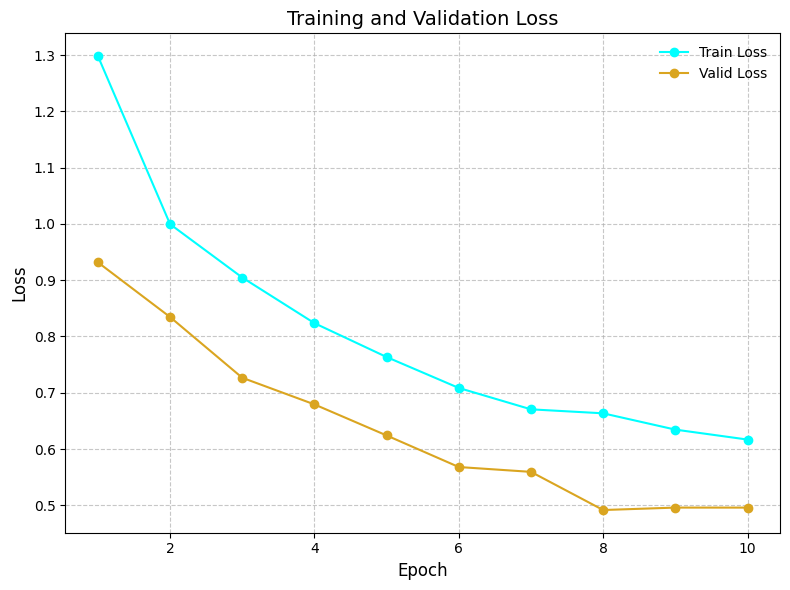

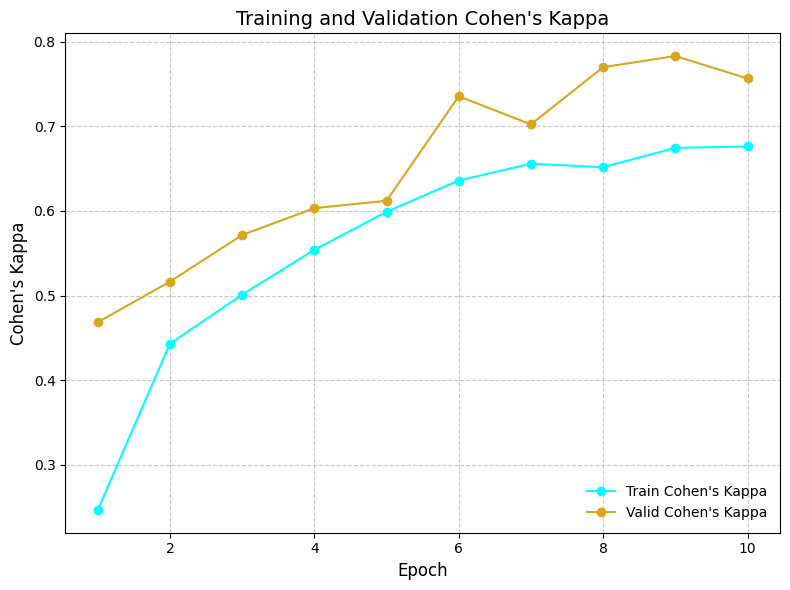

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Example history data (assuming `history` is defined)
history_df = pd.DataFrame(history)

# Plot 1: Loss vs. Epoch
plt.figure(figsize=(8, 6))
plt.plot(history_df['epoch'], history_df['train_loss'], marker='o', color='aqua', label='Train Loss')
plt.plot(history_df['epoch'], history_df['valid_loss'], marker='o', color='goldenrod', label='Valid Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=10, frameon=False)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('loss_vs_epoch.png', dpi=300)  # Save as a high-quality image
plt.show()

# Plot 2: Cohen's Kappa vs. Epoch
plt.figure(figsize=(8, 6))
plt.plot(history_df['epoch'], history_df['train_perf'], marker='o', color='aqua', label='Train Cohen\'s Kappa')
plt.plot(history_df['epoch'], history_df['valid_perf'], marker='o', color='goldenrod', label='Valid Cohen\'s Kappa')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Cohen\'s Kappa', fontsize=12)
plt.title('Training and Validation Cohen\'s Kappa', fontsize=14)
plt.legend(loc='lower right', fontsize=10, frameon=False)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('kappa_vs_epoch.png', dpi=300)  # Save as a high-quality image
plt.show()


In [62]:
history_df

,epoch,train_loss,valid_loss,train_perf,valid_perf
0,1,1.298297,0.931754,0.246700,0.468510
1,2,0.999584,0.834538,0.443116,0.516494
2,3,0.904715,0.726621,0.501072,0.571585
3,4,0.823651,0.679274,0.554054,0.603286
4,5,0.763471,0.624136,0.598922,0.612019
5,6,0.708509,0.568028,0.635969,0.735449
6,7,0.670524,0.559414,0.655787,0.702285
7,8,0.663449,0.491624,0.651652,0.769800
8,9,0.634486,0.495943,0.674517,0.783008
9,10,0.616812,0.495910,0.676200,0.756502


In [63]:
# Compute test performance

best_model.eval()

y_pred_all, y_true_all = list(), list()
for batch_x, batch_y in loader_test:
    batch_x = batch_x.to(device=device, dtype=torch.float32)
    batch_y = batch_y.to(device=device, dtype=torch.int64)
    output = model.forward(batch_x)
    y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
    y_true_all.append(batch_y.cpu().numpy())

y_pred = np.concatenate(y_pred_all)
y_true = np.concatenate(y_true_all)
rec_ids = np.concatenate(  # indicates which recording each example comes from
    [[i] * len(ds) for i, ds in enumerate(test_ds.datasets)])

test_bal_acc = balanced_accuracy_score(y_true, y_pred)
test_kappa = cohen_kappa_score(y_true, y_pred)

print(f'Test balanced accuracy: {test_bal_acc:0.3f}')
print(f'Test Cohen\'s kappa: {test_kappa:0.3f}')

Test balanced accuracy: 0.754
Test Cohen's kappa: 0.676


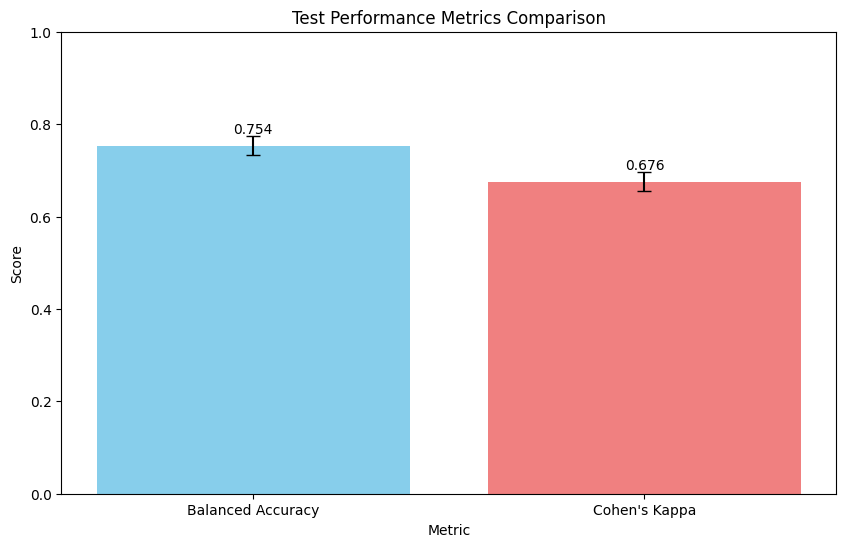

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Define metrics and their names
metrics = ['Balanced Accuracy', 'Cohen\'s Kappa']
values = [test_bal_acc, test_kappa]
errors = [0.02, 0.02]  # Example error values; replace with actual if available

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(metrics, values, yerr=errors, capsize=5, color=['skyblue', 'lightcoral'])

# Add labels and title
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Test Performance Metrics Comparison')
ax.set_ylim(0, 1)  # Set y-axis limit from 0 to 1 for percentage metrics

# Adding value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.3f}', ha='center', va='bottom')

plt.show()


In [65]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(conf_mat, classes_mapping):
    ticks = list(classes_mapping.keys())
    tick_labels = classes_mapping.values()

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(conf_mat, cmap='Reds')

    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title('Confusion matrix')

    for i in range(len(ticks)):
        for j in range(len(ticks)):
            text = ax.text(
                j, i, conf_mat[i, j], ha='center', va='center', color='k')

    fig.colorbar(im, ax=ax, fraction=0.05, label='')
    fig.tight_layout()

    return fig, ax

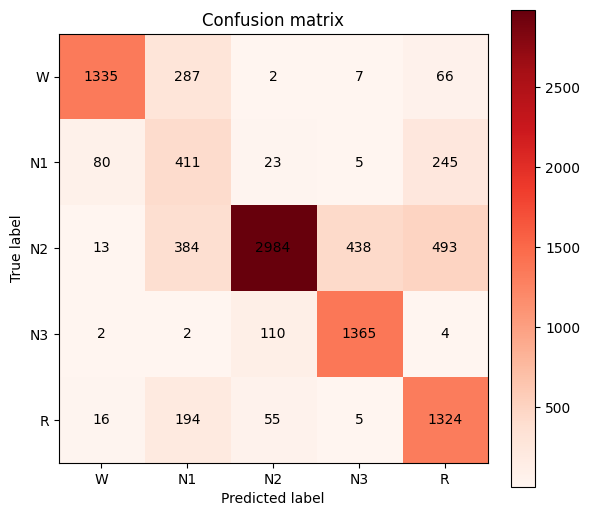

In [66]:
conf_mat = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_mat, classes_mapping);

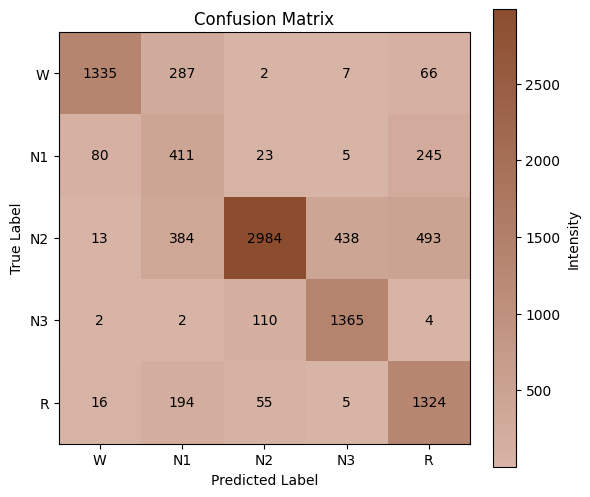

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.colors as mcolors

def plot_confusion_matrix(conf_mat, classes_mapping):
    ticks = list(classes_mapping.keys())
    tick_labels = list(classes_mapping.values())

    fig, ax = plt.subplots(figsize=(6, 6))

   # Define a custom brown colormap
    brown_cmap = mcolors.LinearSegmentedColormap.from_list(
        'brown_gradient', ['#d8b4a6', '#8c4d2f'])  # Light to dark brown

    im = ax.imshow(conf_mat, cmap=brown_cmap)

    # Set the ticks and labels
    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_title('Confusion Matrix')

    # Annotate each cell with the numeric value
    for i in range(len(ticks)):
        for j in range(len(ticks)):
            text = ax.text(
                j, i, conf_mat[i, j], ha='center', va='center', color='black')

    # Add colorbar with "Intensity" label
    cbar = fig.colorbar(im, ax=ax, fraction=0.05)
    cbar.set_label('Intensity')

    fig.tight_layout()

    return fig, ax

# Assuming y_true and y_pred are defined
conf_mat = confusion_matrix(y_true, y_pred)
classes_mapping = {0: 'W', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'R'}

plot_confusion_matrix(conf_mat, classes_mapping)
plt.show()


In [68]:
conf_mat

array([[1335,  287,    2,    7,   66],
       [  80,  411,   23,    5,  245],
       [  13,  384, 2984,  438,  493],
       [   2,    2,  110, 1365,    4],
       [  16,  194,   55,    5, 1324]], dtype=int64)

In [69]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, cohen_kappa_score, accuracy_score

# Assuming you have y_true and y_pred already defined

# Calculate precision, recall, and f1-score for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# Calculate overall precision and accuracy
overall_precision = precision_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)

# Create a classification report
class_report = classification_report(y_true, y_pred, target_names=classes_mapping.values())

# Print the classification report along with additional metrics
print("Classification Report:\n", class_report)
print("\nAdditional Metrics:")
print("Precision (per class):", precision)
print("Recall (per class):", recall)
print("F1 Score (per class):", f1)
print("Overall Precision (Weighted):", overall_precision)
print("Accuracy:", accuracy)
print("Cohen's Kappa:", kappa)

Classification Report:
               precision    recall  f1-score   support

           W       0.92      0.79      0.85      1697
          N1       0.32      0.54      0.40       764
          N2       0.94      0.69      0.80      4312
          N3       0.75      0.92      0.83      1483
           R       0.62      0.83      0.71      1594

    accuracy                           0.75      9850
   macro avg       0.71      0.75      0.72      9850
weighted avg       0.81      0.75      0.77      9850


Additional Metrics:
Precision (per class): [0.92323651 0.32159624 0.94013863 0.75       0.62101313]
Recall (per class): [0.78668238 0.53795812 0.69202226 0.92043156 0.83061481]
F1 Score (per class): [0.84950684 0.40254652 0.79722148 0.82652134 0.7106817 ]
Overall Precision (Weighted): 0.8089801610933406
Accuracy: 0.7531979695431472
Cohen's Kappa: 0.6755745849833806


In [70]:
# from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, cohen_kappa_score, accuracy_score

# # Assuming you have y_true and y_pred already defined

# # Calculate precision, recall, and f1-score for each class
# precision = precision_score(y_true, y_pred, average=None)
# recall = recall_score(y_true, y_pred, average=None)
# f1 = f1_score(y_true, y_pred, average=None)

# # Calculate overall precision and accuracy
# overall_precision = precision_score(y_true, y_pred, average='weighted')
# accuracy = accuracy_score(y_true, y_pred)

# # Calculate Cohen's Kappa
# kappa = cohen_kappa_score(y_true, y_pred)

# # Create a classification report
# class_report = classification_report(y_true, y_pred, target_names=classes_mapping.values())

# # Print the classification report along with additional metrics
# print("Classification Report:\n", class_report)
# print("\nAdditional Metrics:")
# print("Precision (per class):", precision)
# print("Recall (per class):", recall)
# print("F1 Score (per class):", f1)
# print("Overall Precision (Weighted):", overall_precision)
# print("Accuracy:", accuracy)
# print("Cohen's Kappa:", kappa)

In [71]:
import plotly.graph_objects as go
import pandas as pd

# Create a DataFrame for better handling
df = pd.DataFrame({
    'Class': list(classes_mapping.values()),
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

fig = go.Figure()

# Add bars for Precision, Recall, and F1 Score
fig.add_trace(go.Bar(x=df['Class'], y=df['Precision'], name='Precision', marker_color='blue'))
fig.add_trace(go.Bar(x=df['Class'], y=df['Recall'], name='Recall', marker_color='green'))
fig.add_trace(go.Bar(x=df['Class'], y=df['F1 Score'], name='F1 Score', marker_color='orange'))

# Update layout
fig.update_layout(
    title='Precision, Recall, and F1 Score per Class',
    xaxis_title='Class',
    yaxis_title='Score',
    barmode='group'
)

fig.show()


In [72]:
import plotly.express as px

# Create Radar Chart
fig = px.line_polar(df, r='Precision', theta='Class', line_close=True, title='Radar Chart for Precision')
fig.add_scatterpolar(r=df['Recall'], theta=df['Class'], mode='lines', name='Recall')
fig.add_scatterpolar(r=df['F1 Score'], theta=df['Class'], mode='lines', name='F1 Score')

# Update layout
fig.update_layout(
    polar=dict(
        radialaxis=dict(visible=True),
        angularaxis=dict(visible=True)
    )
)

fig.show()


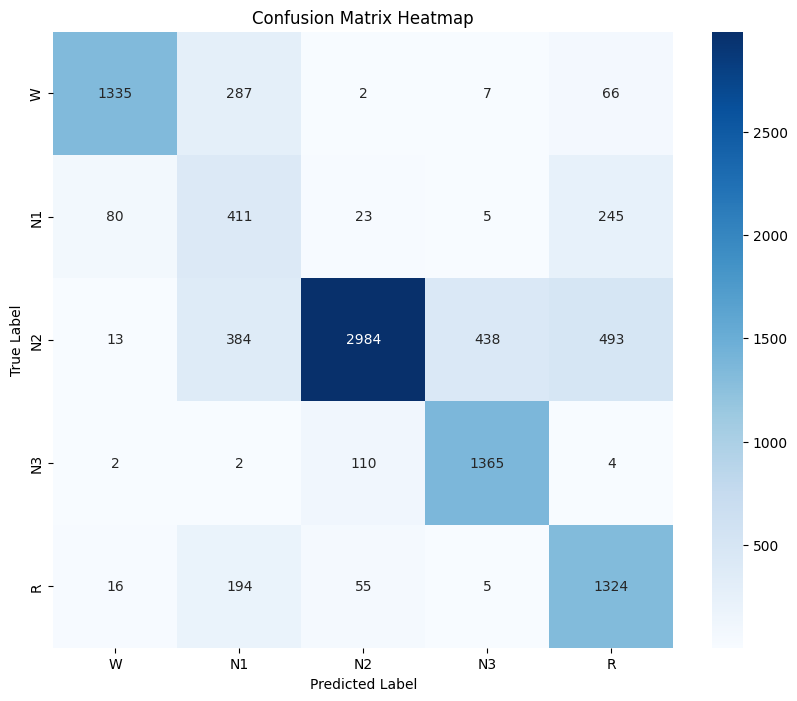

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes_mapping.values(), yticklabels=classes_mapping.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()


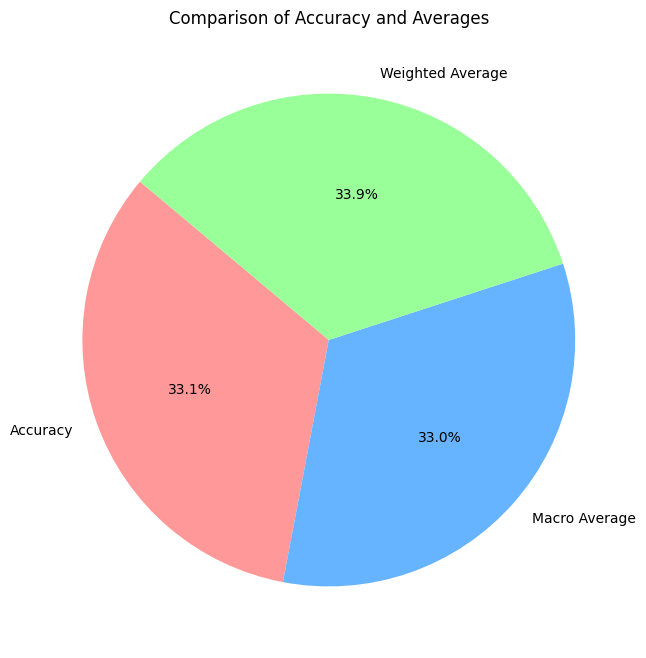

In [74]:
import matplotlib.pyplot as plt

# Data to plot
labels = ['Accuracy', 'Macro Average', 'Weighted Average']
sizes = [accuracy, 0.75, 0.77]  # Macro average F1 and Weighted average F1 scores

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'], startangle=140)
plt.title('Comparison of Accuracy and Averages')
plt.show()


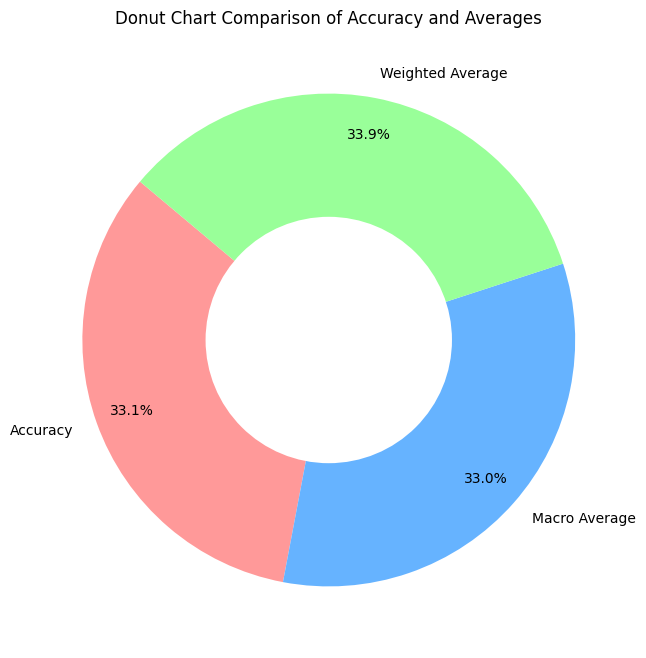

In [75]:
import matplotlib.pyplot as plt

# Data to plot
sizes = [accuracy, 0.75, 0.77]
labels = ['Accuracy', 'Macro Average', 'Weighted Average']

# Create a donut chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'], startangle=140, pctdistance=0.85)

# Draw a circle at the center of the plot to make it look like a donut
centre_circle = plt.Circle((0,0),0.5,fc='white')
fig.gca().add_artist(centre_circle)

plt.title('Donut Chart Comparison of Accuracy and Averages')
plt.show()


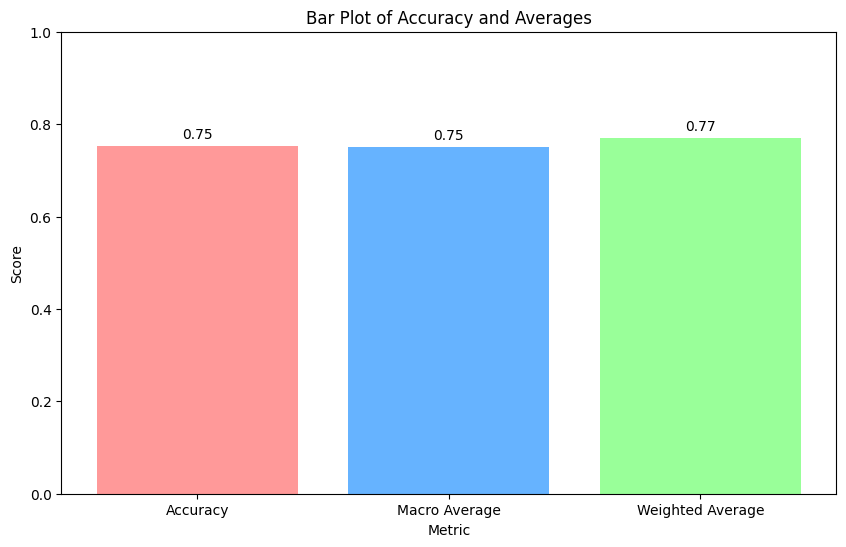

In [76]:
import matplotlib.pyplot as plt

# Data to plot
metrics = ['Accuracy', 'Macro Average', 'Weighted Average']
values = [accuracy, 0.75, 0.77]
colors = ['#ff9999', '#66b3ff', '#99ff99']

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=colors)

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Add labels and title
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Bar Plot of Accuracy and Averages')
plt.ylim(0, 1)  # Adjust y-axis limit if necessary

plt.show()


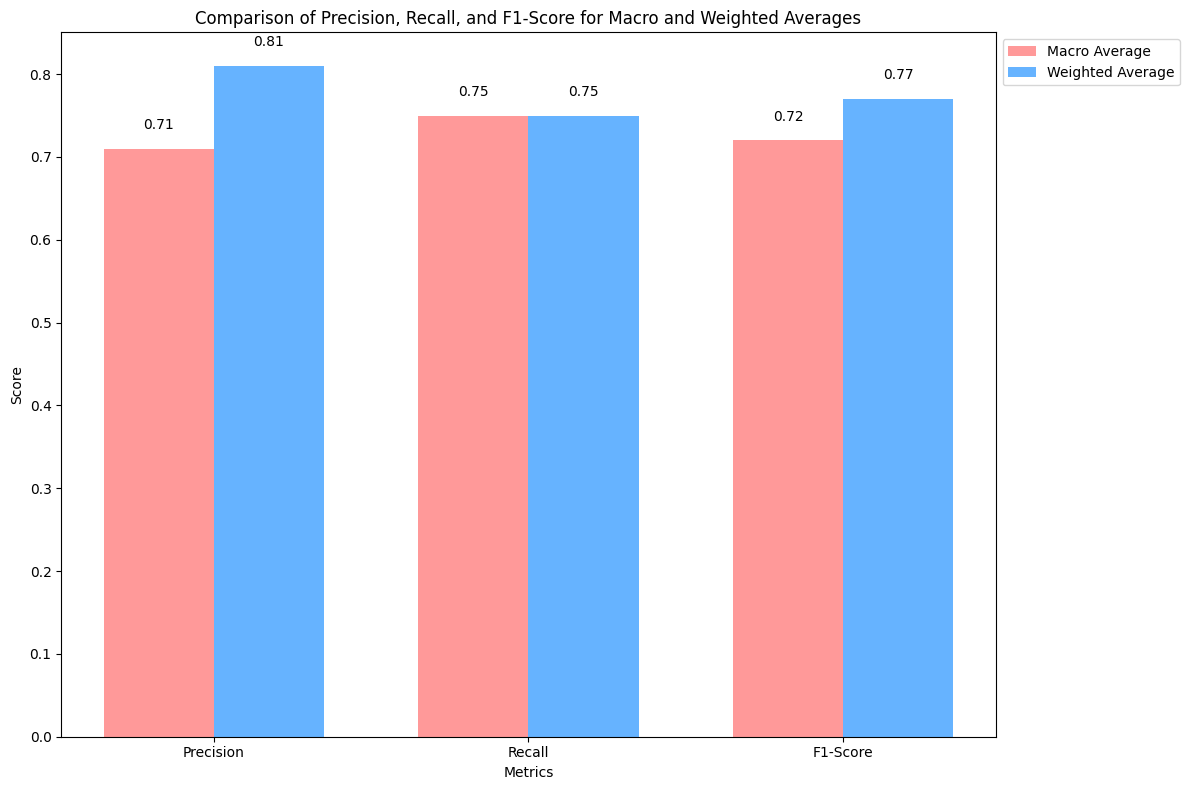

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Data to plot
metrics = ['Precision', 'Recall', 'F1-Score']
macro_avg = [0.71, 0.75, 0.72]
weighted_avg = [0.81, 0.75, 0.77]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

# Create a grouped bar plot
plt.figure(figsize=(12, 8))
bars1 = plt.bar(x - width/2, macro_avg, width, label='Macro Average', color='#ff9999')
bars2 = plt.bar(x + width/2, weighted_avg, width, label='Weighted Average', color='#66b3ff')

# Add value labels on bars with adjusted positioning
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2),
                 ha='center', va='bottom', fontsize=10, color='black')

add_labels(bars1)
add_labels(bars2)

# Add labels, title, and legend
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Comparison of Precision, Recall, and F1-Score for Macro and Weighted Averages')
plt.xticks(x, metrics)

# Move legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to make room for the legend
plt.tight_layout()

plt.show()


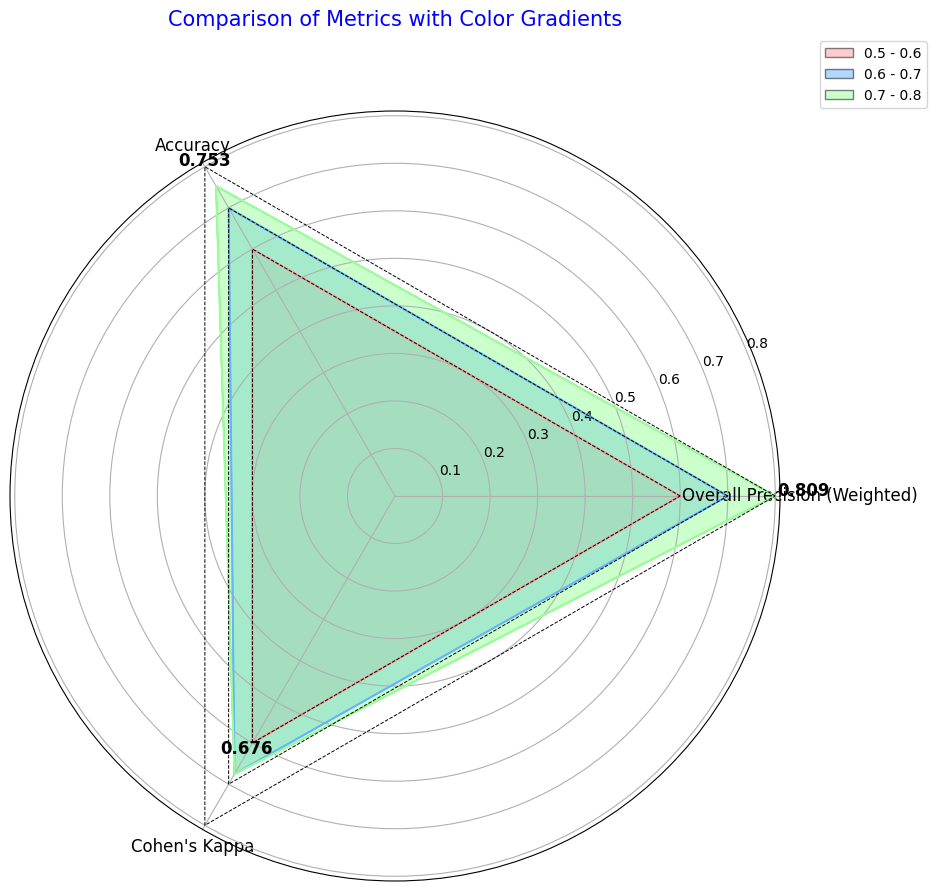

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Data
labels = ['Overall Precision (Weighted)', 'Accuracy', 'Cohen\'s Kappa']
values = [0.8089801610933406, 0.7531979695431472, 0.6755745849833806]

# Number of variables
num_vars = len(labels)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
values += values[:1]  # to close the circle
angles += angles[:1]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Define colors and ranges
colors = ['#ff9999', '#66b3ff', '#99ff99']  # Red, Blue, Green
ranges = [0.6, 0.7, 0.8]  # Value thresholds for colors
color_labels = ['0.5 - 0.6', '0.6 - 0.7', '0.7 - 0.8']

# Draw radar chart with color gradients
for i, (color, threshold) in enumerate(zip(colors, ranges)):
    below_threshold = [v if v < threshold else threshold for v in values]
    ax.fill(angles, below_threshold, color=color, alpha=0.5, edgecolor='black', label=color_labels[i])
    ax.plot(angles, below_threshold, color=color, linewidth=1.5)

# Add thin lines for specific values
for threshold in ranges:
    ax.plot(angles, [threshold] * (num_vars + 1), color='black', linestyle='--', linewidth=0.7)

# Adjust label positions to avoid overlap
for i, (label, angle) in enumerate(zip(labels, angles)):
    x_pos = angle if angle < np.pi else angle - np.pi
    y_offset = 0.05 if angle < np.pi else -0.05
    ax.text(angle, values[i] + y_offset, f'{values[i]:.3f}', horizontalalignment='center', size=12, color='black', weight='semibold')

# Set the labels for the axes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)

# Title and legend
plt.title('Comparison of Metrics with Color Gradients', size=15, color='blue', y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

plt.show()


Below Needed changes!

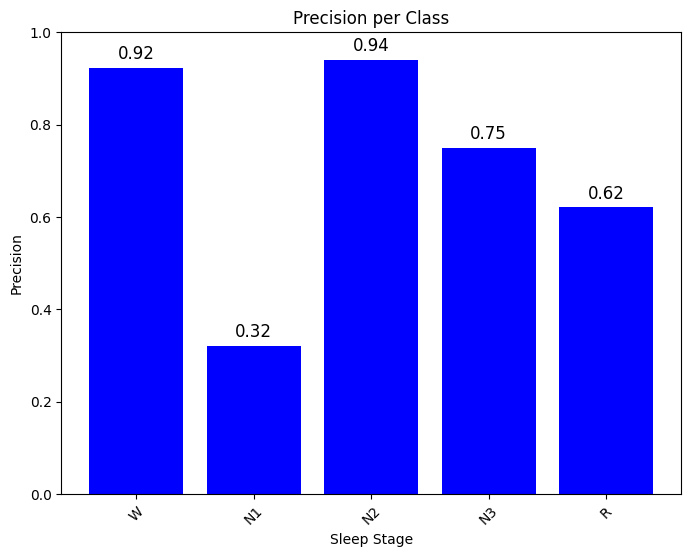

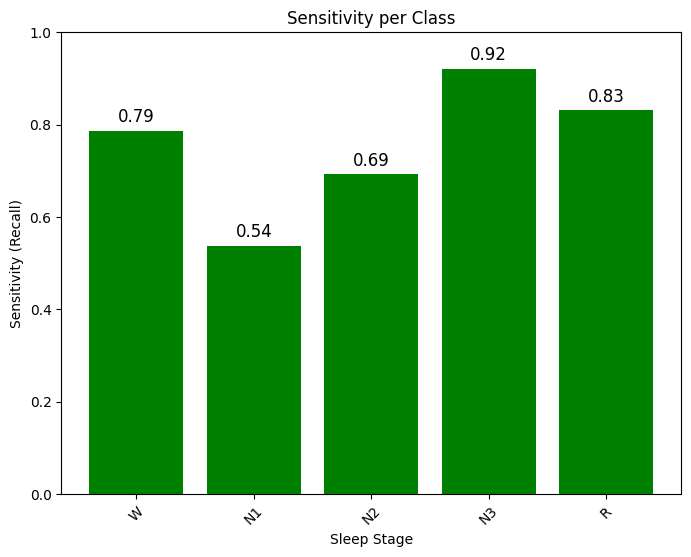

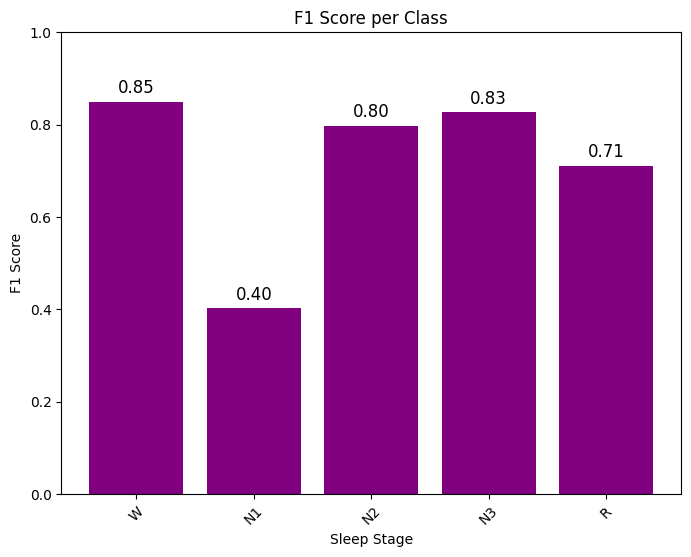

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Replace with your class labels and class indices
class_labels = ['W', 'N1', 'N2', 'N3', 'R']
class_indices = [0, 1, 2, 3, 4]

# Calculate precision scores for each class separately
precision_per_class = precision_score(y_true, y_pred, labels=class_indices, average=None)

# Create a bar plot for precision per class
plt.figure(figsize=(8, 6))
bars = plt.bar(class_labels, precision_per_class, color='blue')
plt.xlabel('Sleep Stage')
plt.ylabel('Precision')
plt.title('Precision per Class')
plt.ylim(0, 1.0)  # Set the y-axis limit from 0 to 1 for better visualization

# Add values on top of the bars with two decimal points
for bar, precision in zip(bars, precision_per_class):
    plt.text(bar.get_x() + bar.get_width() / 2, precision + 0.01, f'{precision:.2f}', ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Calculate recall scores (sensitivity) for each class separately
recall_per_class = recall_score(y_true, y_pred, labels=class_indices, average=None)

# Create a bar plot for sensitivity (recall) per class
plt.figure(figsize=(8, 6))
bars = plt.bar(class_labels, recall_per_class, color='green')
plt.xlabel('Sleep Stage')
plt.ylabel('Sensitivity (Recall)')
plt.title('Sensitivity per Class')
plt.ylim(0, 1.0)  # Set the y-axis limit from 0 to 1 for better visualization

# Add values on top of the bars with two decimal points
for bar, recall in zip(bars, recall_per_class):
    plt.text(bar.get_x() + bar.get_width() / 2, recall + 0.01, f'{recall:.2f}', ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Calculate F1 scores for each class separately
f1_score_per_class = f1_score(y_true, y_pred, labels=class_indices, average=None)

# Create a bar plot for F1 score per class
plt.figure(figsize=(8, 6))
bars = plt.bar(class_labels, f1_score_per_class, color='purple')
plt.xlabel('Sleep Stage')
plt.ylabel('F1 Score')
plt.title('F1 Score per Class')
plt.ylim(0, 1.0)  # Set the y-axis limit from 0 to 1 for better visualization

# Add values on top of the bars with two decimal points
for bar, f1_score in zip(bars, f1_score_per_class):
    plt.text(bar.get_x() + bar.get_width() / 2, f1_score + 0.01, f'{f1_score:.2f}', ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


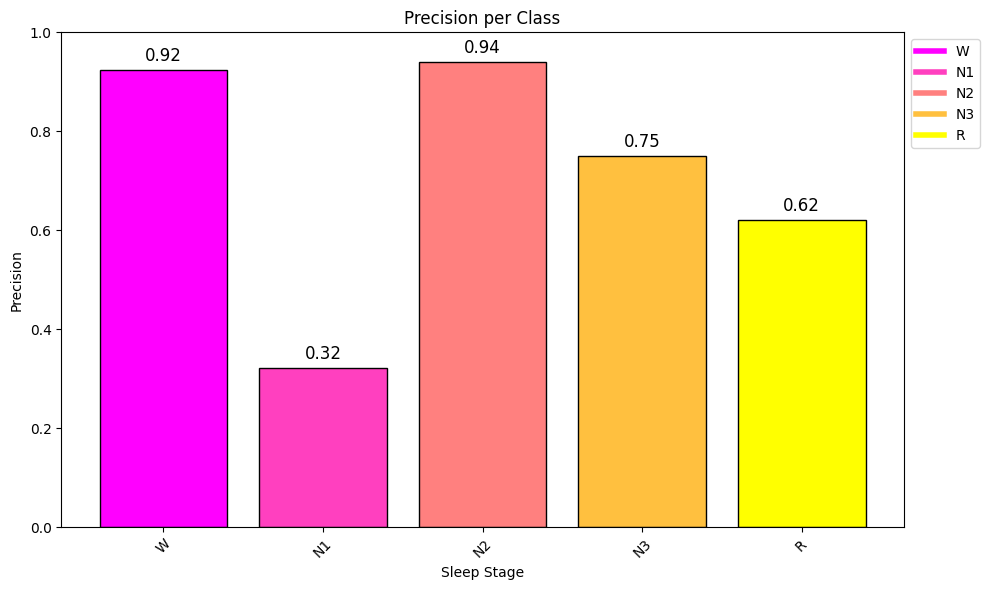

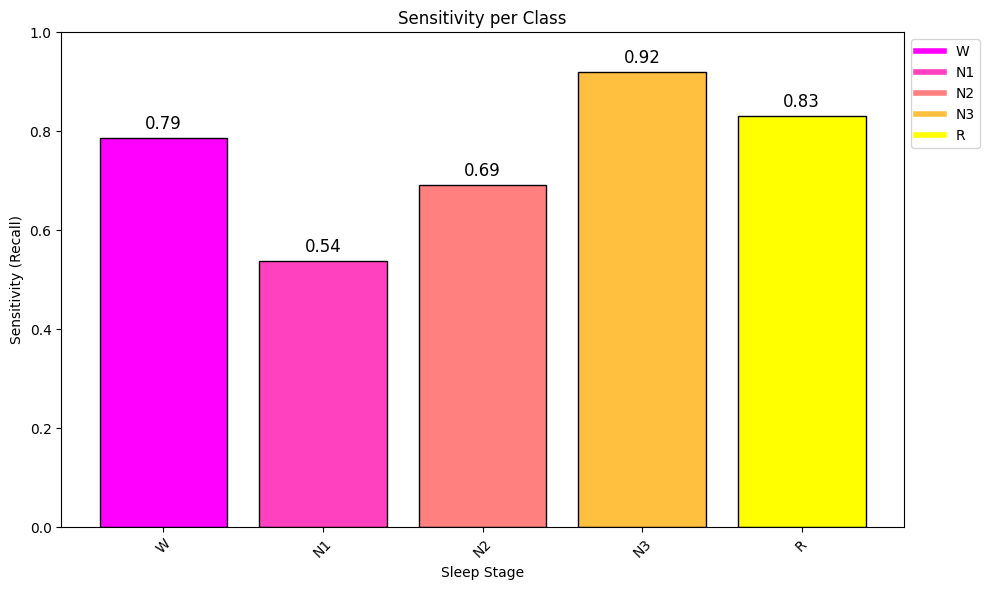

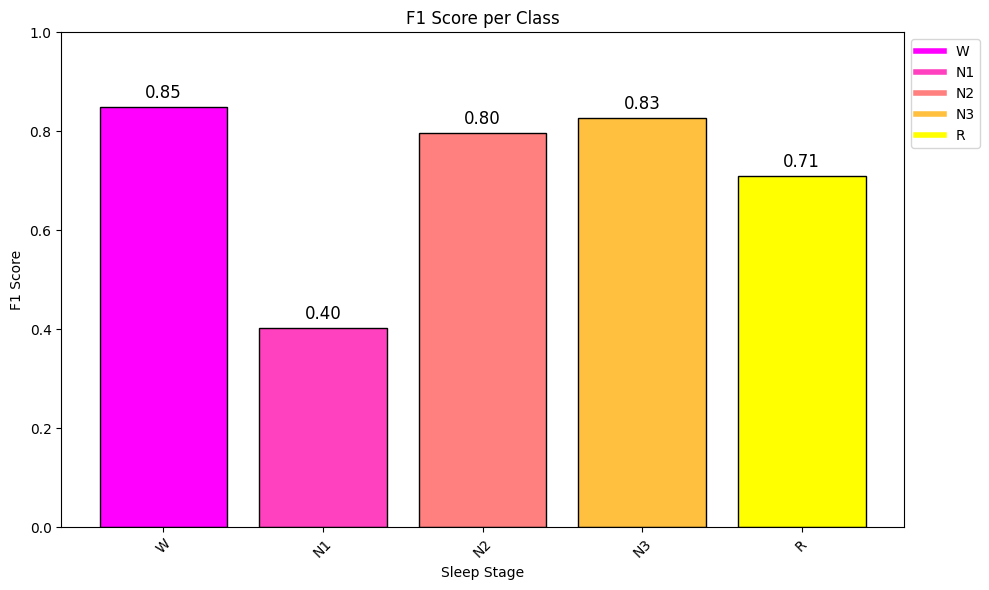

In [80]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from matplotlib.lines import Line2D

# Replace with your class labels and class indices
class_labels = ['W', 'N1', 'N2', 'N3', 'R']
class_indices = [0, 1, 2, 3, 4]

# Define colors for each class
colors = plt.cm.spring(np.linspace(0, 1, len(class_labels)))  # Gradient color

# Function to create a bar plot with colors and custom legend outside
def plot_with_colors(class_labels, scores, colors, ylabel, title, legend_labels):
    plt.figure(figsize=(10, 6))
    
    # Apply color gradient
    bars = plt.bar(class_labels, scores, color=colors, edgecolor='black')
    
    plt.xlabel('Sleep Stage')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(0, 1.0)  # Set the y-axis limit from 0 to 1 for better visualization
    
    # Add values on top of the bars with two decimal points
    for bar, score in zip(bars, scores):
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            score + 0.01, 
            f'{score:.2f}', 
            ha='center', 
            va='bottom', 
            fontsize=12
        )

    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    # Custom legend with colors
    legend_elements = [Line2D([0], [0], color=color, lw=4, label=label) for color, label in zip(colors, legend_labels)]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()  # Adjust layout to fit everything
    plt.show()

# Calculate precision scores for each class separately
precision_per_class = precision_score(y_true, y_pred, labels=class_indices, average=None)
plot_with_colors(
    class_labels, 
    precision_per_class, 
    colors=colors,
    ylabel='Precision', 
    title='Precision per Class', 
    legend_labels=class_labels
)

# Calculate recall scores (sensitivity) for each class separately
recall_per_class = recall_score(y_true, y_pred, labels=class_indices, average=None)
plot_with_colors(
    class_labels, 
    recall_per_class, 
    colors=colors,
    ylabel='Sensitivity (Recall)', 
    title='Sensitivity per Class', 
    legend_labels=class_labels
)

# Calculate F1 scores for each class separately
f1_score_per_class = f1_score(y_true, y_pred, labels=class_indices, average=None)
plot_with_colors(
    class_labels, 
    f1_score_per_class, 
    colors=colors,
    ylabel='F1 Score', 
    title='F1 Score per Class', 
    legend_labels=class_labels
)


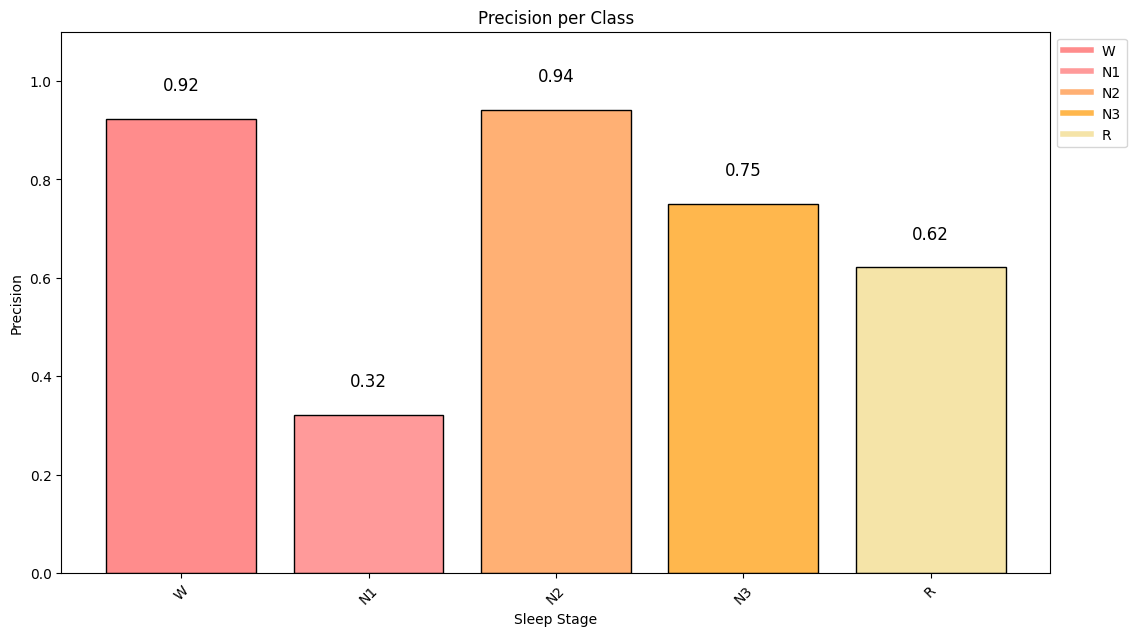

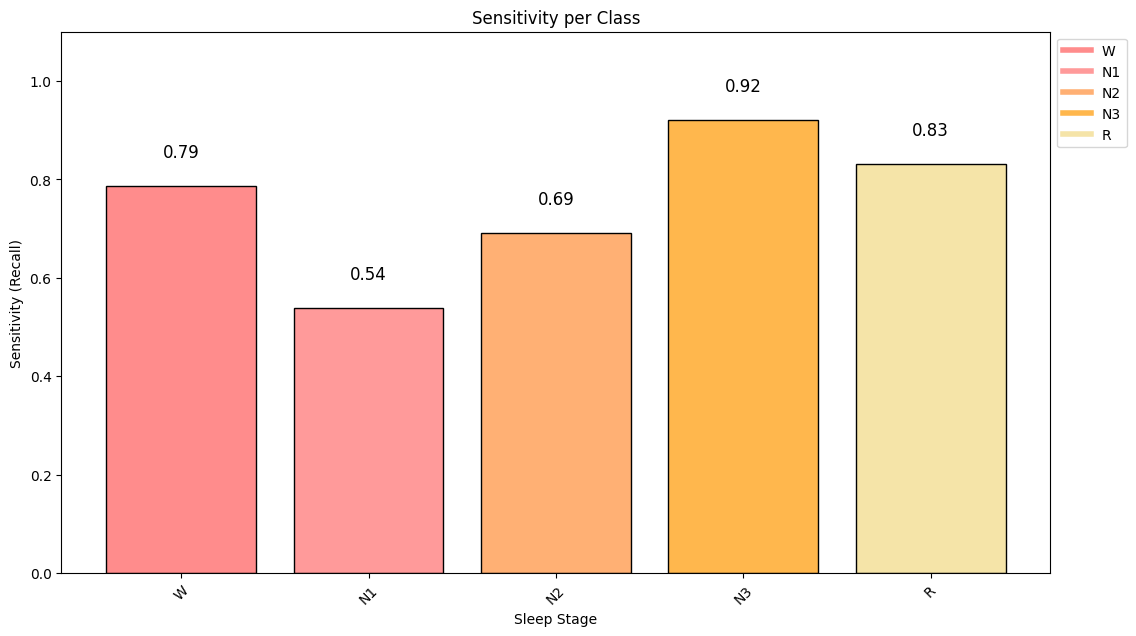

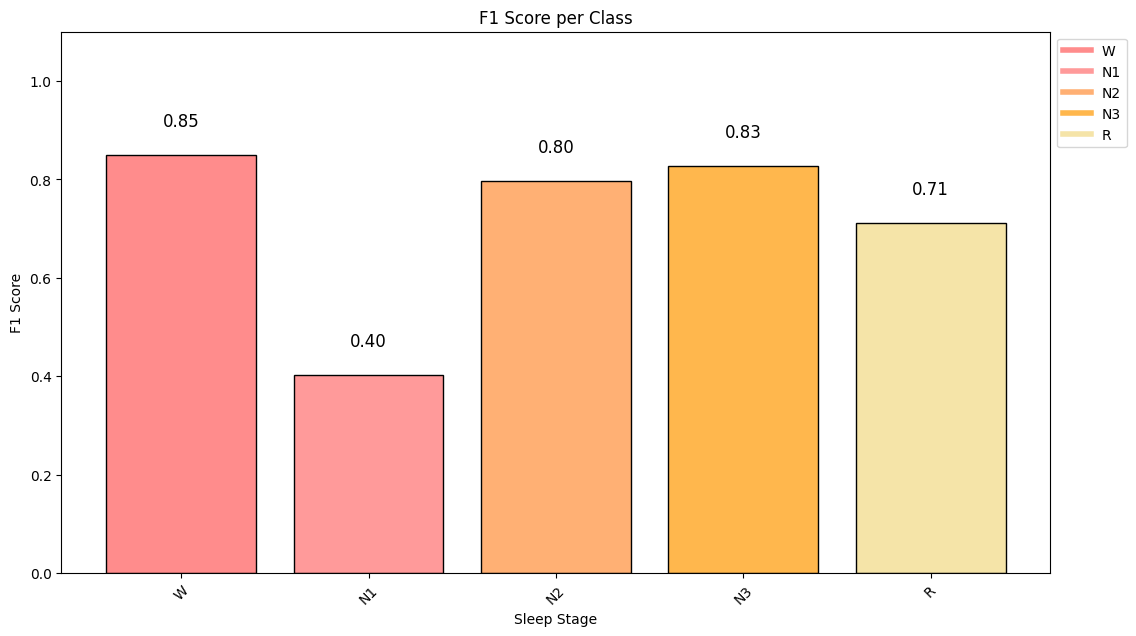

In [81]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from matplotlib.lines import Line2D

# Replace with your class labels and class indices
class_labels = ['W', 'N1', 'N2', 'N3', 'R']
class_indices = [0, 1, 2, 3, 4]

# Define darker shades of colors for each class
colors = ['#FF8C8C', '#FF9A9A', '#FFB074', '#FFB74D', '#F5E4A8']  # Slightly darker shades

# Function to create a bar plot with colors and custom legend outside
def plot_with_colors(class_labels, scores, colors, ylabel, title, legend_labels):
    plt.figure(figsize=(12, 7))  # Increased figure size for better spacing
    
    # Apply colors
    bars = plt.bar(class_labels, scores, color=colors, edgecolor='black')
    
    plt.xlabel('Sleep Stage')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(0, 1.1)  # Set the y-axis limit from 0 to 1.1 for better visualization
    
    # Add values on top of the bars with two decimal points
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            height + 0.05,  # Increased the offset to avoid overlap
            f'{score:.2f}', 
            ha='center', 
            va='bottom', 
            fontsize=12,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6)  # Add background to text
        )

    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    # Custom legend with colors
    legend_elements = [Line2D([0], [0], color=color, lw=4, label=label) for color, label in zip(colors, legend_labels)]
    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout(pad=3.0)  # Adjust layout to fit everything with increased padding
    plt.show()

# Calculate precision scores for each class separately
precision_per_class = precision_score(y_true, y_pred, labels=class_indices, average=None)
plot_with_colors(
    class_labels, 
    precision_per_class, 
    colors=colors,
    ylabel='Precision', 
    title='Precision per Class', 
    legend_labels=class_labels
)

# Calculate recall scores (sensitivity) for each class separately
recall_per_class = recall_score(y_true, y_pred, labels=class_indices, average=None)
plot_with_colors(
    class_labels, 
    recall_per_class, 
    colors=colors,
    ylabel='Sensitivity (Recall)', 
    title='Sensitivity per Class', 
    legend_labels=class_labels
)

# Calculate F1 scores for each class separately
f1_score_per_class = f1_score(y_true, y_pred, labels=class_indices, average=None)
plot_with_colors(
    class_labels, 
    f1_score_per_class, 
    colors=colors,
    ylabel='F1 Score', 
    title='F1 Score per Class', 
    legend_labels=class_labels
)


In [82]:
print("Precision per class:", precision_per_class)
print("Recall per class:", recall_per_class)
print("F1 Score per class:", f1_score_per_class)


Precision per class: [0.92323651 0.32159624 0.94013863 0.75       0.62101313]
Recall per class: [0.78668238 0.53795812 0.69202226 0.92043156 0.83061481]
F1 Score per class: [0.84950684 0.40254652 0.79722148 0.82652134 0.7106817 ]


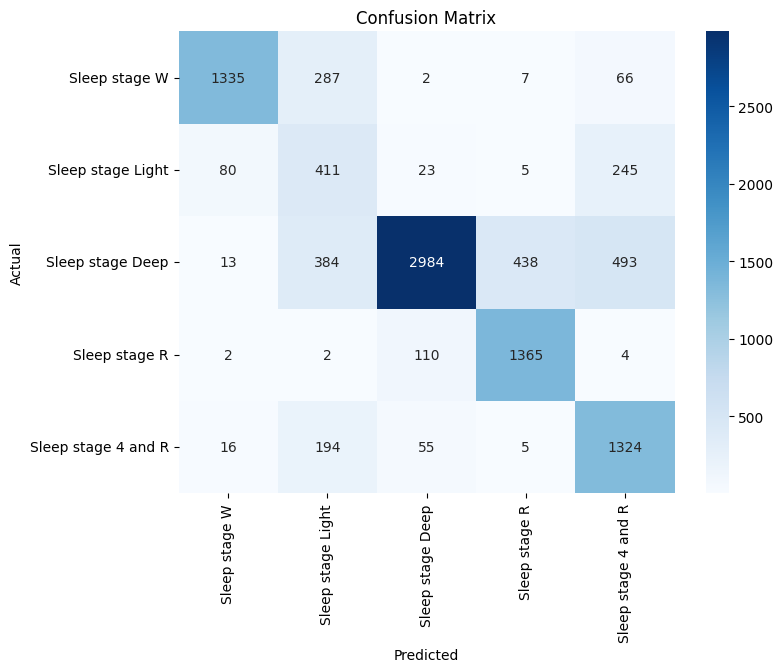

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have y_pred and y_true
confusion_mat = confusion_matrix(y_true, y_pred)

# Define class names
class_names = ['Sleep stage W', 'Sleep stage Light', 'Sleep stage Deep', 'Sleep stage R', 'Sleep stage 4 and R']

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [84]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix

# # Assuming you have y_pred and y_true
# confusion_mat = confusion_matrix(y_true, y_pred)

# # Define class names
# class_names = ['W', 'N1', 'N2', 'N3', 'R']

# # Plot the confusion matrix using Seaborn with a brown color scheme
# plt.figure(figsize=(8, 6))
# ax = sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="copper", xticklabels=class_names, yticklabels=class_names)

# # Add the color bar with an intensity label
# cbar = ax.collections[0].colorbar
# cbar.set_label('Intensity')

# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()


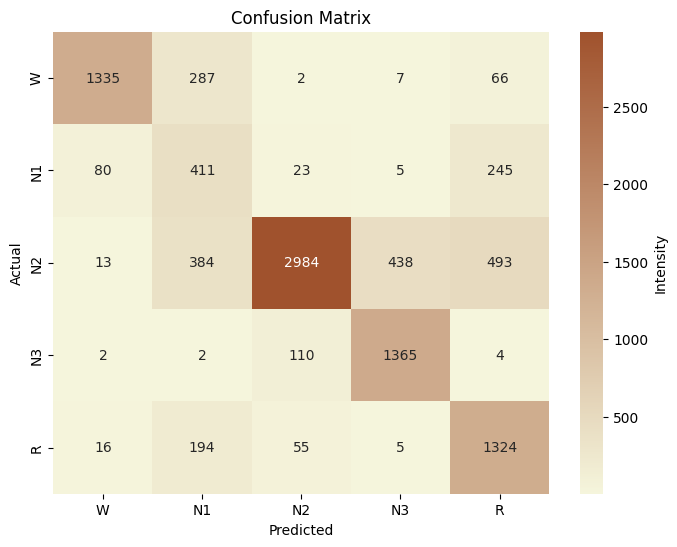

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.colors as mcolors

# Assuming you have y_pred and y_true
confusion_mat = confusion_matrix(y_true, y_pred)

# Define class names
class_names = ['W', 'N1', 'N2', 'N3', 'R']

# Create a custom brown colormap
brown_cmap = mcolors.LinearSegmentedColormap.from_list('brown', ['#F5F5DC', '#A0522D'])

# Plot the confusion matrix using Seaborn with the custom brown color scheme
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_mat, annot=True, fmt="d", cmap=brown_cmap, xticklabels=class_names, yticklabels=class_names)

# Add the color bar with an intensity label
cbar = ax.collections[0].colorbar
cbar.set_label('Intensity')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [86]:
precision

0.6210131332082551

In [87]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(10, 6))

# # Define the new 5 class labels
# classes = ['Sleep stage W', 'Sleep stage Light', 'Sleep stage Deep', 'Sleep stage R', 'Sleep stage 4 and R']

# x = range(len(classes))
# print(x)
# bar_width = 0.2

# precision_bars = plt.bar(x, precision, width=bar_width, label='Precision')
# recall_bars = plt.bar([i + bar_width for i in x], recall, width=bar_width, label='Recall')
# f1_score_bars = plt.bar([i + 2 * bar_width for i in x], f1_score, width=bar_width, label='F1 Score')

# plt.xlabel('Sleep Stage')
# plt.ylabel('Score')
# plt.title('Precision, Recall, and F1 Score for Each Class (5 Classes)')
# plt.xticks([i + bar_width for i in x], classes)
# plt.legend()

# # Add values on top of the bars
# def add_values_on_bars(bars):
#     for bar in bars:
#         height = bar.get_height()
#         ax.annotate(f'{height:.2f}',
#                     xy=(bar.get_x() + bar.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom', fontsize=10)

# add_values_on_bars(precision_bars)
# add_values_on_bars(recall_bars)
# add_values_on_bars(f1_score_bars)

# plt.tight_layout()
# plt.show()


Below Code Takes 1 hour + Time To Run So Dont Touch Unless Dont Need!

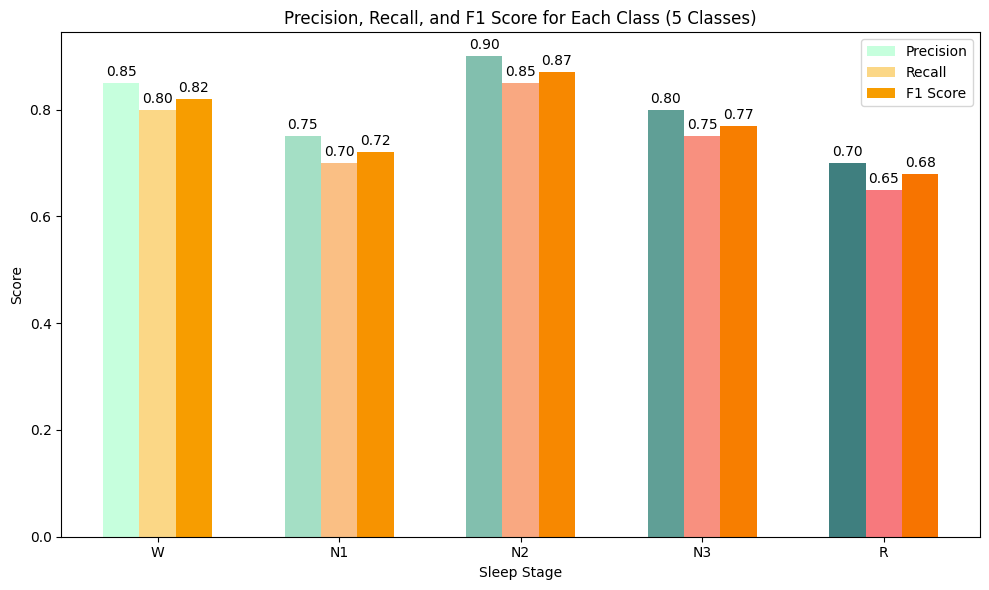

In [88]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define gradient colors for each metric
precision_cmap = LinearSegmentedColormap.from_list('precision_grad', ['#c6ffdd', '#3f7f7f'])
recall_cmap = LinearSegmentedColormap.from_list('recall_grad', ['#fbd786', '#f7797d'])
f1_score_cmap = LinearSegmentedColormap.from_list('f1_score_grad', ['#f79d00', '#f77400'])

# Define the new 5 class labels
classes = ['W', 'N1', 'N2', 'N3', 'R']

x = np.arange(len(classes))
bar_width = 0.2

# Example precision, recall, and F1 score values
precision = [0.85, 0.75, 0.90, 0.80, 0.70]
recall = [0.80, 0.70, 0.85, 0.75, 0.65]
f1_score = [0.82, 0.72, 0.87, 0.77, 0.68]

fig, ax = plt.subplots(figsize=(10, 6))

# Apply different gradient colors
precision_bars = ax.bar(x - bar_width, precision, width=bar_width, label='Precision',
                        color=precision_cmap(np.linspace(0, 1, len(precision))))
recall_bars = ax.bar(x, recall, width=bar_width, label='Recall',
                     color=recall_cmap(np.linspace(0, 1, len(recall))))
f1_score_bars = ax.bar(x + bar_width, f1_score, width=bar_width, label='F1 Score',
                       color=f1_score_cmap(np.linspace(0, 1, len(f1_score))))

ax.set_xlabel('Sleep Stage')
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, and F1 Score for Each Class (5 Classes)')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

# Add values on top of the bars
def add_values_on_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_values_on_bars(precision_bars)
add_values_on_bars(recall_bars)
add_values_on_bars(f1_score_bars)

plt.tight_layout()
plt.show()


In [89]:
# # Define the metric function (e.g., cohen_kappa_score)
# from sklearn.metrics import cohen_kappa_score

# # Initialize empty lists to store training and validation metrics during training
# train_losses, train_perfs, valid_losses, valid_perfs = [], [], [], []

# # Training loop
# for epoch in range(1, n_epochs + 1):
#     train_loss, train_perf = _do_train(
#         model, loader_train, optimizer, criterion, device, metric=cohen_kappa_score)
#     valid_loss, valid_perf = _validate(
#         model, loader_valid, criterion, device, metric=cohen_kappa_score)

#     # Append training and validation metrics to lists
#     train_losses.append(train_loss)
#     train_perfs.append(train_perf)
#     valid_losses.append(valid_loss)
#     valid_perfs.append(valid_perf)

#     # Rest of the code remains the same
#     ...

# # Plot the training and validation metrics together
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))

# # Plot training and validation loss
# plt.subplot(1, 2, 1)    
# plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
# plt.plot(range(1, n_epochs + 1), valid_losses, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Training and Validation Loss')

# # Plot training and validation performance (e.g., Cohen's kappa)
# plt.subplot(1, 2, 2)
# plt.plot(range(1, n_epochs + 1), train_perfs, label='Training Performance')
# plt.plot(range(1, n_epochs + 1), valid_perfs, label='Validation Performance')
# plt.xlabel('Epochs')
# plt.ylabel('Performance')
# plt.legend()
# plt.title('Training and Validation Performance')

# plt.tight_layout()
# plt.show()

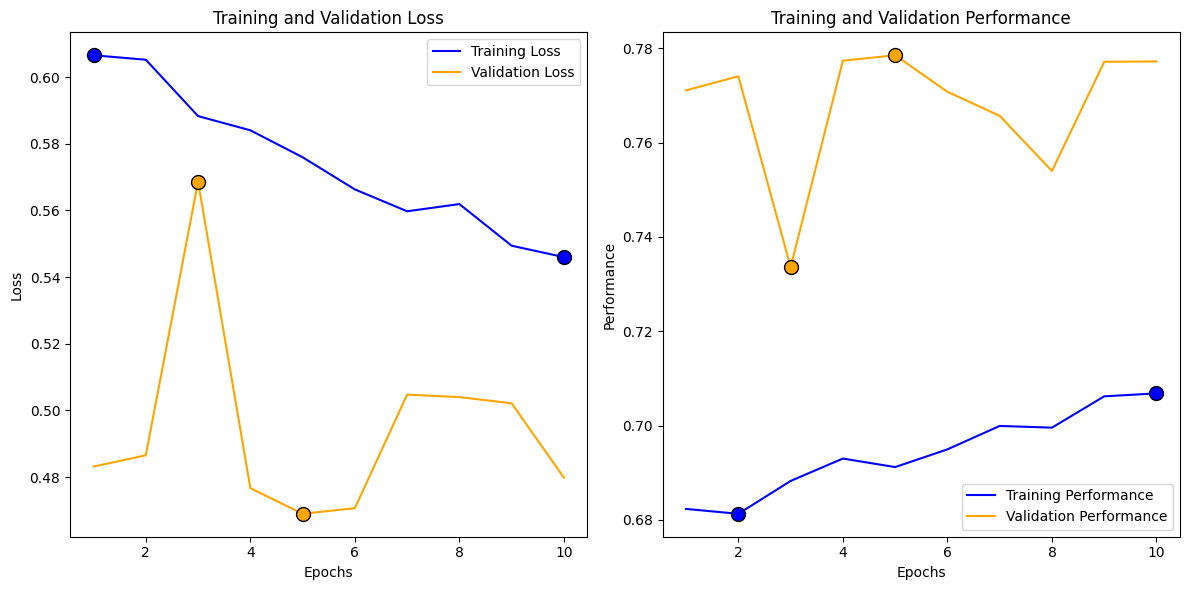

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Define the metric function (e.g., cohen_kappa_score)
from sklearn.metrics import cohen_kappa_score

# Initialize empty lists to store training and validation metrics during training
train_losses, train_perfs, valid_losses, valid_perfs = [], [], [], []

# Training loop
for epoch in range(1, n_epochs + 1):
    train_loss, train_perf = _do_train(
        model, loader_train, optimizer, criterion, device, metric=cohen_kappa_score)
    valid_loss, valid_perf = _validate(
        model, loader_valid, criterion, device, metric=cohen_kappa_score)

    # Append training and validation metrics to lists
    train_losses.append(train_loss)
    train_perfs.append(train_perf)
    valid_losses.append(valid_loss)
    valid_perfs.append(valid_perf)

    # Rest of the code remains the same
    ...

# Plot the training and validation metrics together
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)    
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, n_epochs + 1), valid_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Add dots for max/min points
train_loss_max = np.max(train_losses)
train_loss_min = np.min(train_losses)
valid_loss_max = np.max(valid_losses)
valid_loss_min = np.min(valid_losses)

plt.scatter(np.argmax(train_losses) + 1, train_loss_max, color='blue', edgecolor='black', s=100, zorder=5, label='Max Training Loss')
plt.scatter(np.argmin(train_losses) + 1, train_loss_min, color='blue', edgecolor='black', s=100, zorder=5, label='Min Training Loss')
plt.scatter(np.argmax(valid_losses) + 1, valid_loss_max, color='orange', edgecolor='black', s=100, zorder=5, label='Max Validation Loss')
plt.scatter(np.argmin(valid_losses) + 1, valid_loss_min, color='orange', edgecolor='black', s=100, zorder=5, label='Min Validation Loss')

# Plot training and validation performance (e.g., Cohen's kappa)
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_perfs, label='Training Performance', color='blue')
plt.plot(range(1, n_epochs + 1), valid_perfs, label='Validation Performance', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Performance')
plt.legend()
plt.title('Training and Validation Performance')

# Add dots for max/min points
train_perf_max = np.max(train_perfs)
train_perf_min = np.min(train_perfs)
valid_perf_max = np.max(valid_perfs)
valid_perf_min = np.min(valid_perfs)

plt.scatter(np.argmax(train_perfs) + 1, train_perf_max, color='blue', edgecolor='black', s=100, zorder=5, label='Max Training Performance')
plt.scatter(np.argmin(train_perfs) + 1, train_perf_min, color='blue', edgecolor='black', s=100, zorder=5, label='Min Training Performance')
plt.scatter(np.argmax(valid_perfs) + 1, valid_perf_max, color='orange', edgecolor='black', s=100, zorder=5, label='Max Validation Performance')
plt.scatter(np.argmin(valid_perfs) + 1, valid_perf_min, color='orange', edgecolor='black', s=100, zorder=5, label='Min Validation Performance')

plt.tight_layout()
plt.show()


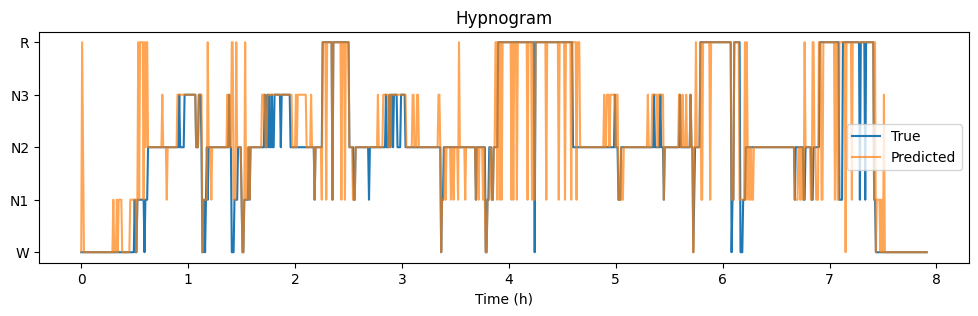

In [91]:
# Plot hypnogram for one recording

mask = rec_ids == 3  # pick a recording number

t = np.arange(len(y_true[mask])) * 30 / 3600

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(t, y_true[mask], label='True')
ax.plot(t, y_pred[mask], alpha=0.7, label='Predicted')
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_yticklabels(['W', 'N1', 'N2', 'N3', 'R'])
ax.set_xlabel('Time (h)')
ax.set_title('Hypnogram')
ax.legend()